# Chapter 7: Timestamped data

Accompanying code for the book [The Art of Feature Engineering](http://artoffeatureengineering.com).

This notebook plus notebooks for the other chapters are available online at https://github.com/DrDub/artfeateng


## MIT License

Copyright 2019 Pablo Duboue

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Limitations

* Simple python intented for people coming from other languages that plan to use the ideas described in the book outside of Python.
* Many of these techniques are available as library calls. They are spelled out as for teaching purposes.
* Resource limitations:
 * At most one day of running time per notebook.
 * No GPU required.
 * Minimal dependencies.
 * At most 8Gb of RAM.
* Due to resource limitations, these notebooks do not undergo as much hyperparameter tuning as necessary. This is a shortcoming of these case studies, keep it in mind if you want to follow a similar path with your experiments.
* To help readers try variants of some cells in isolation, the cells are easily executable without having to re-run the whole notebook. As such, most cells read everything they need from disk and write all their results back into disk, which is unnecessary with normal notebooks. The code for each cell might look long and somewhat unusual. In a sense, each cell tries to be a separate Python program.
* I dislike Pandas so these notebooks are Pandas-free, which might seem unusual to some.

# Chapter 7: Case Study on Timestamped Data

In this chapter I will describe the creation of the extended version of WikiCities dataset with historical data. I will also present a country population prediction task to exemplify traditional time series algorithms.


## WikiCities: Historical

Used the following historical versions of DBpedia:

<table>
<tr><th>Version</th><th>Year</th><th>Code</th></tr>
<tr><td>3.6</td><td>2010</td><td>dbpedia10</td></tr>
<tr><td>3.7</td><td>2011</td><td>dbpedia11</td></tr>
<tr><td>3.8</td><td>2012</td><td>dbpedia12</td></tr>
<tr><td>3.9</td><td>2013</td><td>dbpedia13</td></tr>
<tr><td>2014</td><td>2014</td><td>dbpedia14</td></tr>
<tr><td>2015-04</td><td>2015</td><td>dbpedia15</td></tr>
</table>

Using scripts outside of this notebook, I have extracted the relevant triples from the dumps for all years into files CODE_cities1000_base.ttl (e.g., dbpedia12_cities1000_base.ttl). Because due to changes in the script (going from or "Phoenix%2C_Arizona" to "Phoenix,_Arizona") and in the source Wikipedia (going from "Utrecht" to "Utrecht_%28city%29"), the entity designators change from year to year, I have tried to standardize them using the provided GeoNames link for each year. In the historical versions the GeoNames data was limited and as many as half the cities are missing. This might also be due to lower coverage in the source Wikipedia in the earlier years. All in all, this represents the type of challenges of dealing with historical data in production systems.

From these files, I extracted the conservative feature set into CODE_dev_conservative.tsv, also outside the notebooks. This produced files CODE_dev_conservative.tsv. Again, due to changes in the ontology many columns (sometimes up to 50% of the columns) are empty. Interestingly, this number changes from year to year (not necessarily starting low and increasing). Therefore, it enables the specific type of temporal imputation enabled by timestamped data.

Let us start doing some EDA and see how this data set behaves.

## EDA: Exploratory Data Analysis

The first thing to take a look is how the total number of relations behaves year after year (Cell #1).

Plotting on 44,959


<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

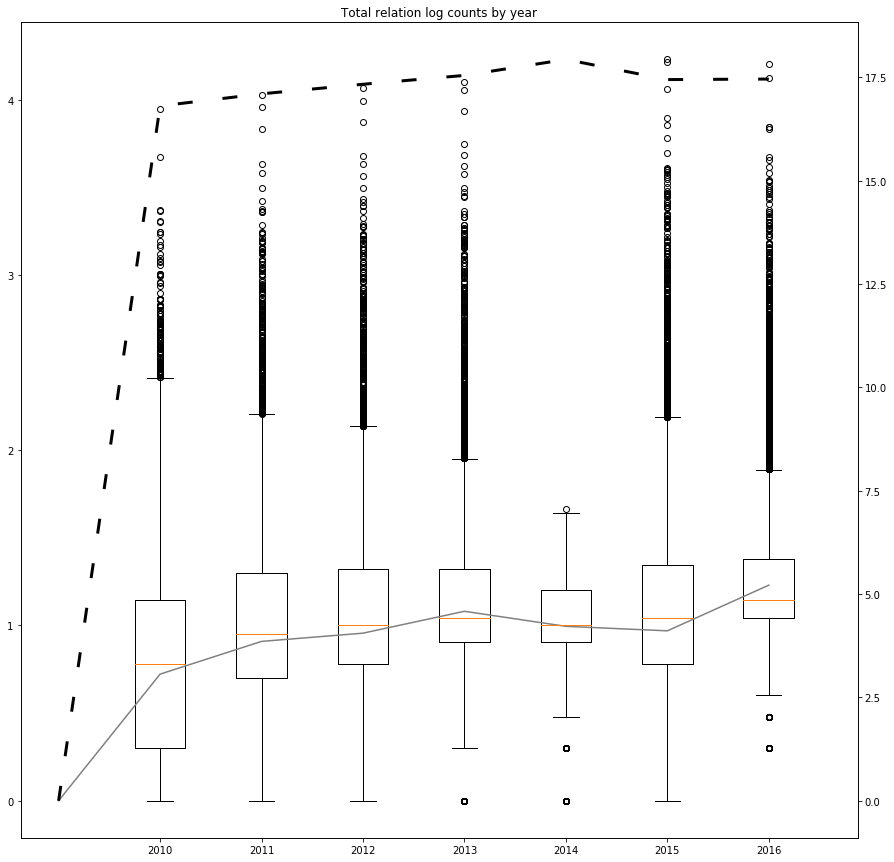

In [1]:
# CELL 1
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

dbpedia_rels = [
    1, # padding
    19969604, # 2010
    26770236, # 2011
    33742028, # 2012
    41804713, # 2013
    61481509, # 2014
    37791134, # 2015
    38285149 # 2016
]

city_col = 0
rel_col = 1
to_plot = list()
means = list()
city_to_data = None
deleted_cities = set()
for version in range(7):
    datafile = "dbpedia1" + str(version) + "_dev_conservative.tsv"
    if version == 6:
        datafile = "ch6_cell32_dev_feat_conservative.tsv"
    city_relcounts = dict()
    with open(datafile) as f:
        first = True
        for line in f:
            fields = line.split("\t")
            if first:
                first = False
                if fields[city_col] != 'name':
                    raise Exception("Expected 'name', got " + fields[city_col])
                if fields[rel_col] != 'rel#count':
                    raise Exception("Expected 'rel#count', got " + fields[rel_col])
            else:
                city_relcounts[fields[city_col]] = float(fields[rel_col])
    if city_to_data is None:
        city_to_data = dict()
        for city, rel in city_relcounts.items():
            city_to_data[city] = [ rel ]
    else:
        to_delete = list()
        for city, l in city_to_data.items():
            if city in city_relcounts:
                l.append(city_relcounts[city])
            else:
                deleted_cities.add(city)
                to_delete.append(city)
        for city in to_delete:
            del city_to_data[city]
print("Plotting on {:,}".format(len(city_to_data)))
cities = sorted(list(city_to_data.keys()))
for version in range(7):
    relcounts = np.array([ city_to_data[city][version] for city in cities])
    to_plot.append(relcounts)
    means.append(np.mean(relcounts))
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ax.set_title('Total relation log counts by year')
ax.boxplot(to_plot, labels=list(range(2010,2017)), meanline=True)
means.insert(0,0)
ax.plot(range(8), means, 'b-', color='gray')
ax2 = ax.twinx()
ax2.plot(list(map(math.log,dbpedia_rels)), linestyle=(0,(5,10)), color='black', linewidth=3.0)
plt.savefig("ch7_cell1_boxplot.pdf", bbox_inches='tight', dpi=300)
plt

Interestingly, the average number of relations has not increased  as much as the average increase of DBpedia.

Let us see the behaviour of this number as related to the last year (Cell #2).

Plotting on 44,959


<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

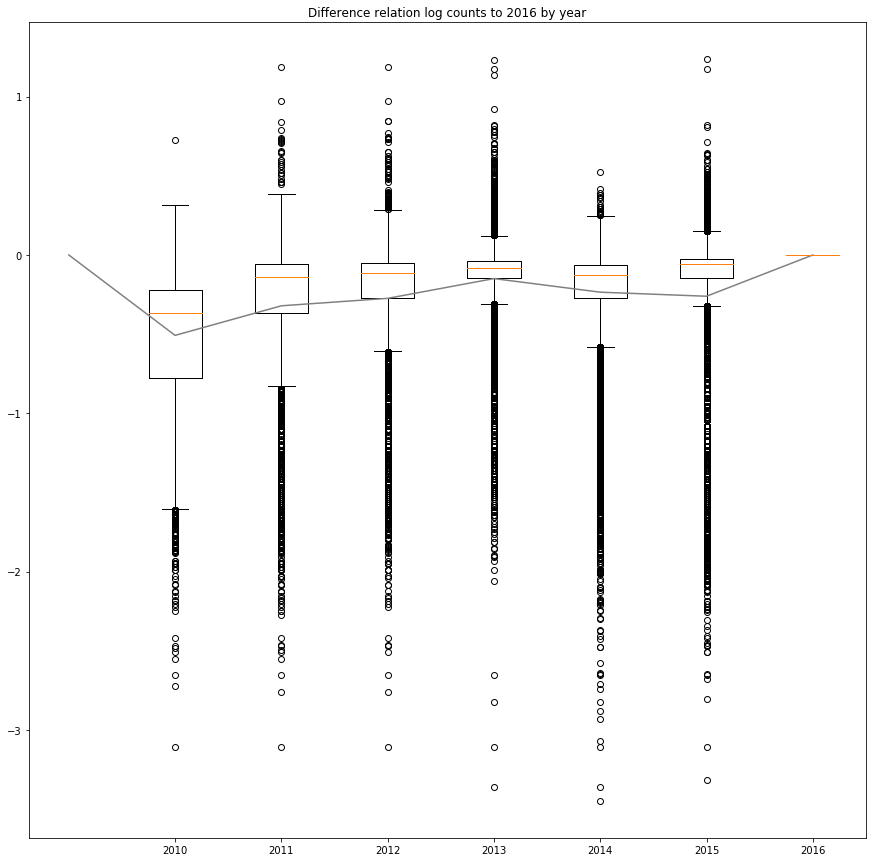

In [2]:
# CELL 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

city_col = 0
rel_col = 1
to_plot = list()
means = list()
city_to_data = None
deleted_cities = set()
for version in range(7):
    datafile = "dbpedia1" + str(version) + "_dev_conservative.tsv"
    if version == 6:
        datafile = "ch6_cell32_dev_feat_conservative.tsv"
    city_relcounts = dict()
    with open(datafile) as f:
        first = True
        for line in f:
            fields = line.split("\t")
            if first:
                first = False
                if fields[city_col] != 'name':
                    raise Exception("Expected 'name', got " + fields[city_col])
                if fields[rel_col] != 'rel#count':
                    raise Exception("Expected 'rel#count', got " + fields[rel_col])
            else:
                city_relcounts[fields[city_col]] = float(fields[rel_col])
    if city_to_data is None:
        city_to_data = dict()
        for city, rel in city_relcounts.items():
            city_to_data[city] = [ rel ]
    else:
        to_delete = list()
        for city, l in city_to_data.items():
            if city in city_relcounts:
                l.append(city_relcounts[city])
            else:
                deleted_cities.add(city)
                to_delete.append(city)
        for city in to_delete:
            del city_to_data[city]
print("Plotting on {:,}".format(len(city_to_data)))
cities = sorted(list(city_to_data.keys()))
for version in range(7):
    relcounts = np.array([ city_to_data[city][version] - city_to_data[city][-1] for city in cities ])
    to_plot.append(relcounts)
    means.append(np.mean(relcounts))
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ax.set_title('Difference relation log counts to 2016 by year')
ax.boxplot(to_plot, labels=list(range(2010,2017)), meanline=True)
means.insert(0,0)
ax.plot(range(8), means, 'b-', color='gray')
plt.savefig("ch7_cell2_boxplot.pdf", bbox_inches='tight', dpi=300)
plt

Let us now take a look at the number of different features to the current year (Cell #3).

Plotting on 44,959


<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

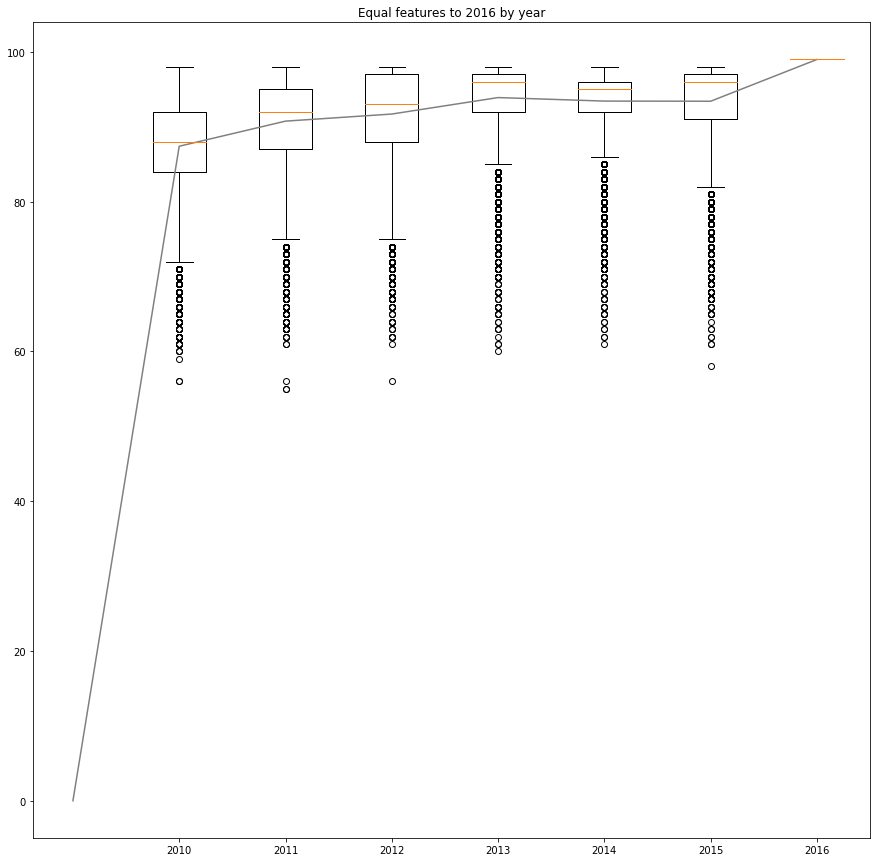

In [3]:
# CELL 3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

city_col = 0
to_plot = list()
means = list()
city_to_data = None
deleted_cities = set()
for version in range(7):
    datafile = "dbpedia1" + str(version) + "_dev_conservative.tsv"
    if version == 6:
        datafile = "ch6_cell32_dev_feat_conservative.tsv"
    this_city_data = dict()
    with open(datafile) as f:
        next(f) # drop header
        for line in f:
            fields = line.split("\t")
            this_city_data[fields[city_col]] = list(map(float,fields[1:]))
    if city_to_data is None:
        city_to_data = dict()
        for city, data in this_city_data.items():
            city_to_data[city] = [ data ]
    else:
        to_delete = list()
        for city, l in city_to_data.items():
            if city in this_city_data:
                l.append(this_city_data[city])
            else:
                deleted_cities.add(city)
                to_delete.append(city)
        for city in to_delete:
            del city_to_data[city]
print("Plotting on {:,}".format(len(city_to_data)))
cities = sorted(list(city_to_data.keys()))
for version in range(7):
    equal_counts = list()
    for city in cities:
        equal_count = 0
        for idx in range(len(city_to_data[city][-1])):
            if city_to_data[city][version][idx] == city_to_data[city][-1][idx]:
                equal_count += 1
        equal_counts.append(equal_count)
    equal_counts = np.array(equal_counts)
    to_plot.append(equal_counts)
    means.append(np.mean(equal_counts))
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ax.set_title('Equal features to 2016 by year')
ax.boxplot(to_plot, labels=list(range(2010,2017)), meanline=True)
means.insert(0,0)
ax.plot(range(8), means, 'b-', color='gray')
plt.savefig("ch7_cell3_boxplot.pdf", bbox_inches='tight', dpi=300)
plt

The trend is similar to the one observed in the rel count alone. This data seems reasonable for trying lagged features but temporal smoothing using a sliding window might provide better results given the bouncy behaviour of the data.

To conclude the EDA, let us take a look at the behaviour of the difference between the target variable, population 
(Cell #4).

Plotting on 30,380
Year 2010, different: 21,054 (69.302172%)
Year 2011, different: 16,327 (53.742594%)
Year 2012, different: 12,211 (40.194207%)
Year 2013, different: 8,543 (28.120474%)
Year 2014, different: 6,207 (20.431205%)
Year 2015, different: 4,541 (14.947334%)
Year 2016, different: 0 (0.000000%)


<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

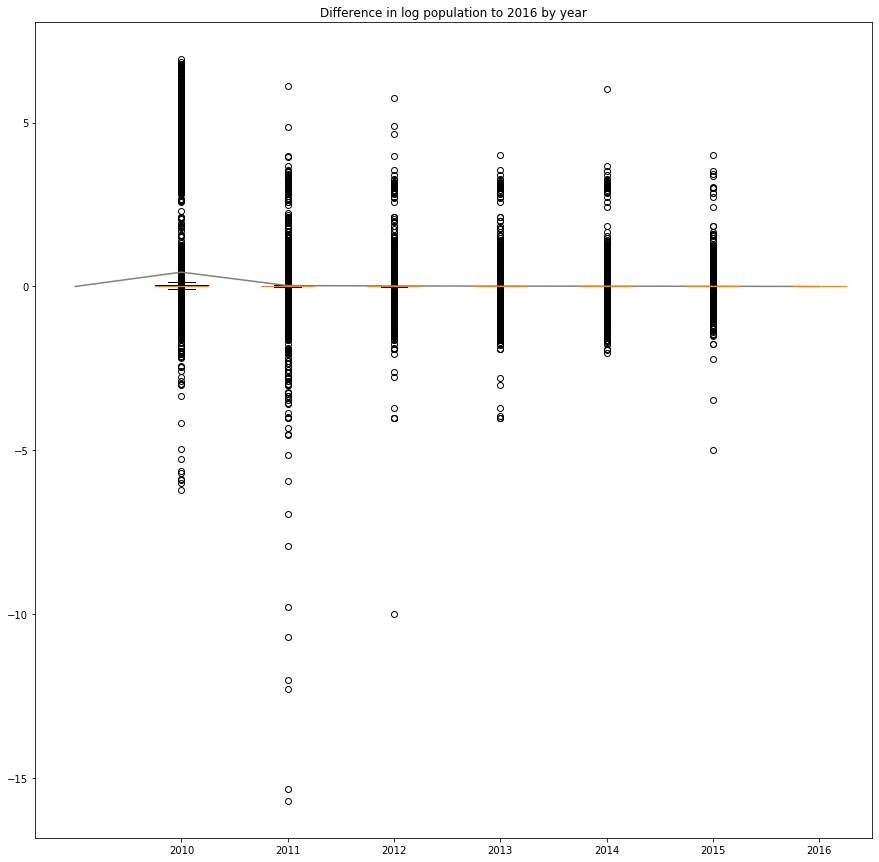

In [4]:
# CELL 4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

city_col = 0
pop_col = 99
to_plot = list()
means = list()
city_to_data = None
deleted_cities = set()
for version in range(7):
    datafile = "dbpedia1" + str(version) + "_dev_conservative.tsv"
    if version == 6:
        datafile = "ch6_cell32_dev_feat_conservative.tsv"
    city_pop  = dict()
    with open(datafile) as f:
        first = True
        for line in f:
            fields = line.strip().split("\t")
            if first:
                first = False
                if fields[city_col] != 'name':
                    raise Exception("Expected 'name', got " + fields[city_col])
                if fields[pop_col] != 'population':
                    raise Exception("Expected 'population', got " + fields[pop_col])
            else:
                city_pop[fields[city_col]] = float(fields[pop_col])
    if city_to_data is None:
        city_to_data = dict()
        for city, rel in city_pop.items():
            city_to_data[city] = [ rel ]
    else:
        to_delete = list()
        for city, l in city_to_data.items():
            if city in city_pop and city_pop[city] > 0:
                l.append(city_pop[city])
            else:
                deleted_cities.add(city)
                to_delete.append(city)
        for city in to_delete:
            del city_to_data[city]
print("Plotting on {:,}".format(len(city_to_data)))
cities = sorted(list(city_to_data.keys()))
for version in range(7):
    pops = np.array([ city_to_data[city][-1] - city_to_data[city][version] for city in cities])
    nonzero = np.count_nonzero(pops)
    print("Year {}, different: {:,} ({:%})".format(2010+version, nonzero, nonzero / len(pops)))
    to_plot.append(pops)
    means.append(np.mean(pops))
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ax.set_title('Difference in log population to 2016 by year')
ax.boxplot(to_plot, labels=list(range(2010,2017)), meanline=True)
means.insert(0,0)
ax.plot(range(8), means, 'b-', color='gray')
plt.savefig("ch7_cell4_boxplot.pdf", bbox_inches='tight', dpi=300)
plt

Interestingly, the population numbers have changed since 2010 until 2016, even though census happen in different countries once every ten years. Also, restricting to the cities with known population for all the years does not show any bump in 2015 as in the other years. Initially, I would have expected the target population will be so accurate that giving it to the ML will constitute a target leak. While the actual number might not be the exact number,  the box plot shows the number is on average the same, with some marked outliers.

Let's try to study the missing values now.

### Missing values

There are two sources for needs of missing values:

1. Empty relation for that year (the whole column will be empty)
1. Missing city for that year (the whole row will be empty)

I will detect these two cases, making an indicator feature for each cell based on these two sources and saving them for further imputation (Cell #5).

In [5]:
# CELL 5
import random
import math
import numpy as np
from collections import OrderedDict

rand = random.Random(42)

# get data sizes
VERSIONS=6 # + 1 for current

with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    FEATS = len(next(f).split('\t')) - 1 # name
    CITIES = 0
    for _ in f:
        CITIES += 1

# load data
CITY_COL = 0
header_line = None
city_names = OrderedDict() # name to idx

table = np.zeros( (CITIES, FEATS * 2 * VERSIONS + FEATS) )

with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    header_line = next(f)
    city_idx = 0
    for line in f:
        fields = line.strip().split("\t")
        floats = list(map(float,fields[1:]))
        for idx, val in enumerate(floats):
            if math.isnan(val):
                floats[idx] = 0.0
        table[city_idx,-FEATS:] = floats
        city_names[fields[CITY_COL]] = city_idx
        city_idx += 1
header = header_line.strip().split("\t")

year_defined = { city: set() for city in city_names }
for version in range(VERSIONS):
    with open("dbpedia1" + str(version) + "_dev_conservative.tsv") as f:
        header_line = next(f)
        for line in f:
            fields = line.strip().split("\t")
            city = fields[CITY_COL]
            city_idx = city_names.get(city, None)
            if city_idx is None:
                continue
            year_defined[city].add(version)
            floats = list(map(float,fields[1:]))
            for idx, val in enumerate(floats):
                table[city_idx,FEATS * 2 * version + 2 * idx] = 1.0 # defined
                if math.isnan(val):
                    table[city_idx,FEATS * 2 * version + 2 * idx + 1] = 0.0
                else:
                    table[city_idx,FEATS * 2 * version + 2 * idx + 1] = val

# column-based missing values: determine empty/constant columns
empty_cols_per_year = list()
for version in range(VERSIONS):
    empty_cols = 0
    for col in range(FEATS):
        value = None
        constant = True
        for city_idx in range(CITIES):
            this_val = table[city_idx, 2 * version * FEATS + 2 * col + 1]
            if value is None:
                value = this_val
            elif value != this_val:
                constant = False
                break
        if constant:
            empty_cols += 1
            table[:, 2 * version * FEATS + 2 * col] = 0.0 # missing
    empty_cols_per_year.append(empty_cols)
print("Total empty cols {:,}".format(sum(empty_cols_per_year)))
for version in range(6):
    print("Empty cols for {}: {}".format(2010+version, empty_cols_per_year[version]))
print("Working on {:,} cities".format(CITIES))

# row-based imputation: determine empty years
empty_rows_per_year = list()
for version in range(6):
    empty_rows = 0
    for city, city_idx in city_names.items():
        if version not in year_defined[city] or \
        all(map(lambda x:table[city_idx, 2*version * FEATS + 2 * x + 1] == 0.0, range(FEATS))):
            empty_rows += 1
            for col in range(FEATS):
                table[city_idx, 2 * version * FEATS + 2 * col] = 0.0
    empty_rows_per_year.append(empty_rows)
print("Total empty rows {:,}".format(sum(empty_rows_per_year)))
for version in range(6):
    print("Empty rows for {}: {}".format(2010+version, empty_rows_per_year[version]))

# write feature table
missing_cells = 0
total_cells = 0
with open("ch7_cell5_dev_missing.tsv", "w") as w:
    w.write('name')
    for version in range(VERSIONS):
        for featname in header[1:]:
            w.write("\t{}_{}?is_defined".format(2010+version, featname))
            w.write("\t{}_{}".format(2010+version, featname))
    w.write('\t' + '\t'.join(header[1:]) + "\n")
    for city, city_idx in city_names.items():
        w.write(city + "\t" + "\t".join(map(str, table[city_idx,:])) + "\n")
        total_cells += FEATS * VERSIONS
        for version in range(VERSIONS):
            for col in range(FEATS):
                if table[city_idx, 2 * version * FEATS + 2 * col] == 0.0:
                    missing_cells += 1
print("Total cells: {:,} missing: {:,} ({:%})".format(total_cells, missing_cells, missing_cells / total_cells))

Total empty cols 186
Empty cols for 2010: 37
Empty cols for 2011: 29
Empty cols for 2012: 29
Empty cols for 2013: 29
Empty cols for 2014: 62
Empty cols for 2015: 0
Working on 44,959 cities
Total empty rows 37,144
Empty rows for 2010: 9990
Empty rows for 2011: 8147
Empty rows for 2012: 6808
Empty rows for 2013: 2160
Empty rows for 2014: 1538
Empty rows for 2015: 8501
Total cells: 26,705,646 missing: 11,078,309 (41.483022%)


There is a significant amount of missing values. Let us see if we can visualize now individual entries. For visualization, I'll use a heatmap, discretizing features into up to six bins using k-means clustering. The top three clusters will be shown in green, the bottom in blue. Missing values will be shown in red.

The graph aligns features for each year to follow them, uncovering the story of the data (Cell #6).

Mérida,_Yucatán: 5.986 (970,376 people)


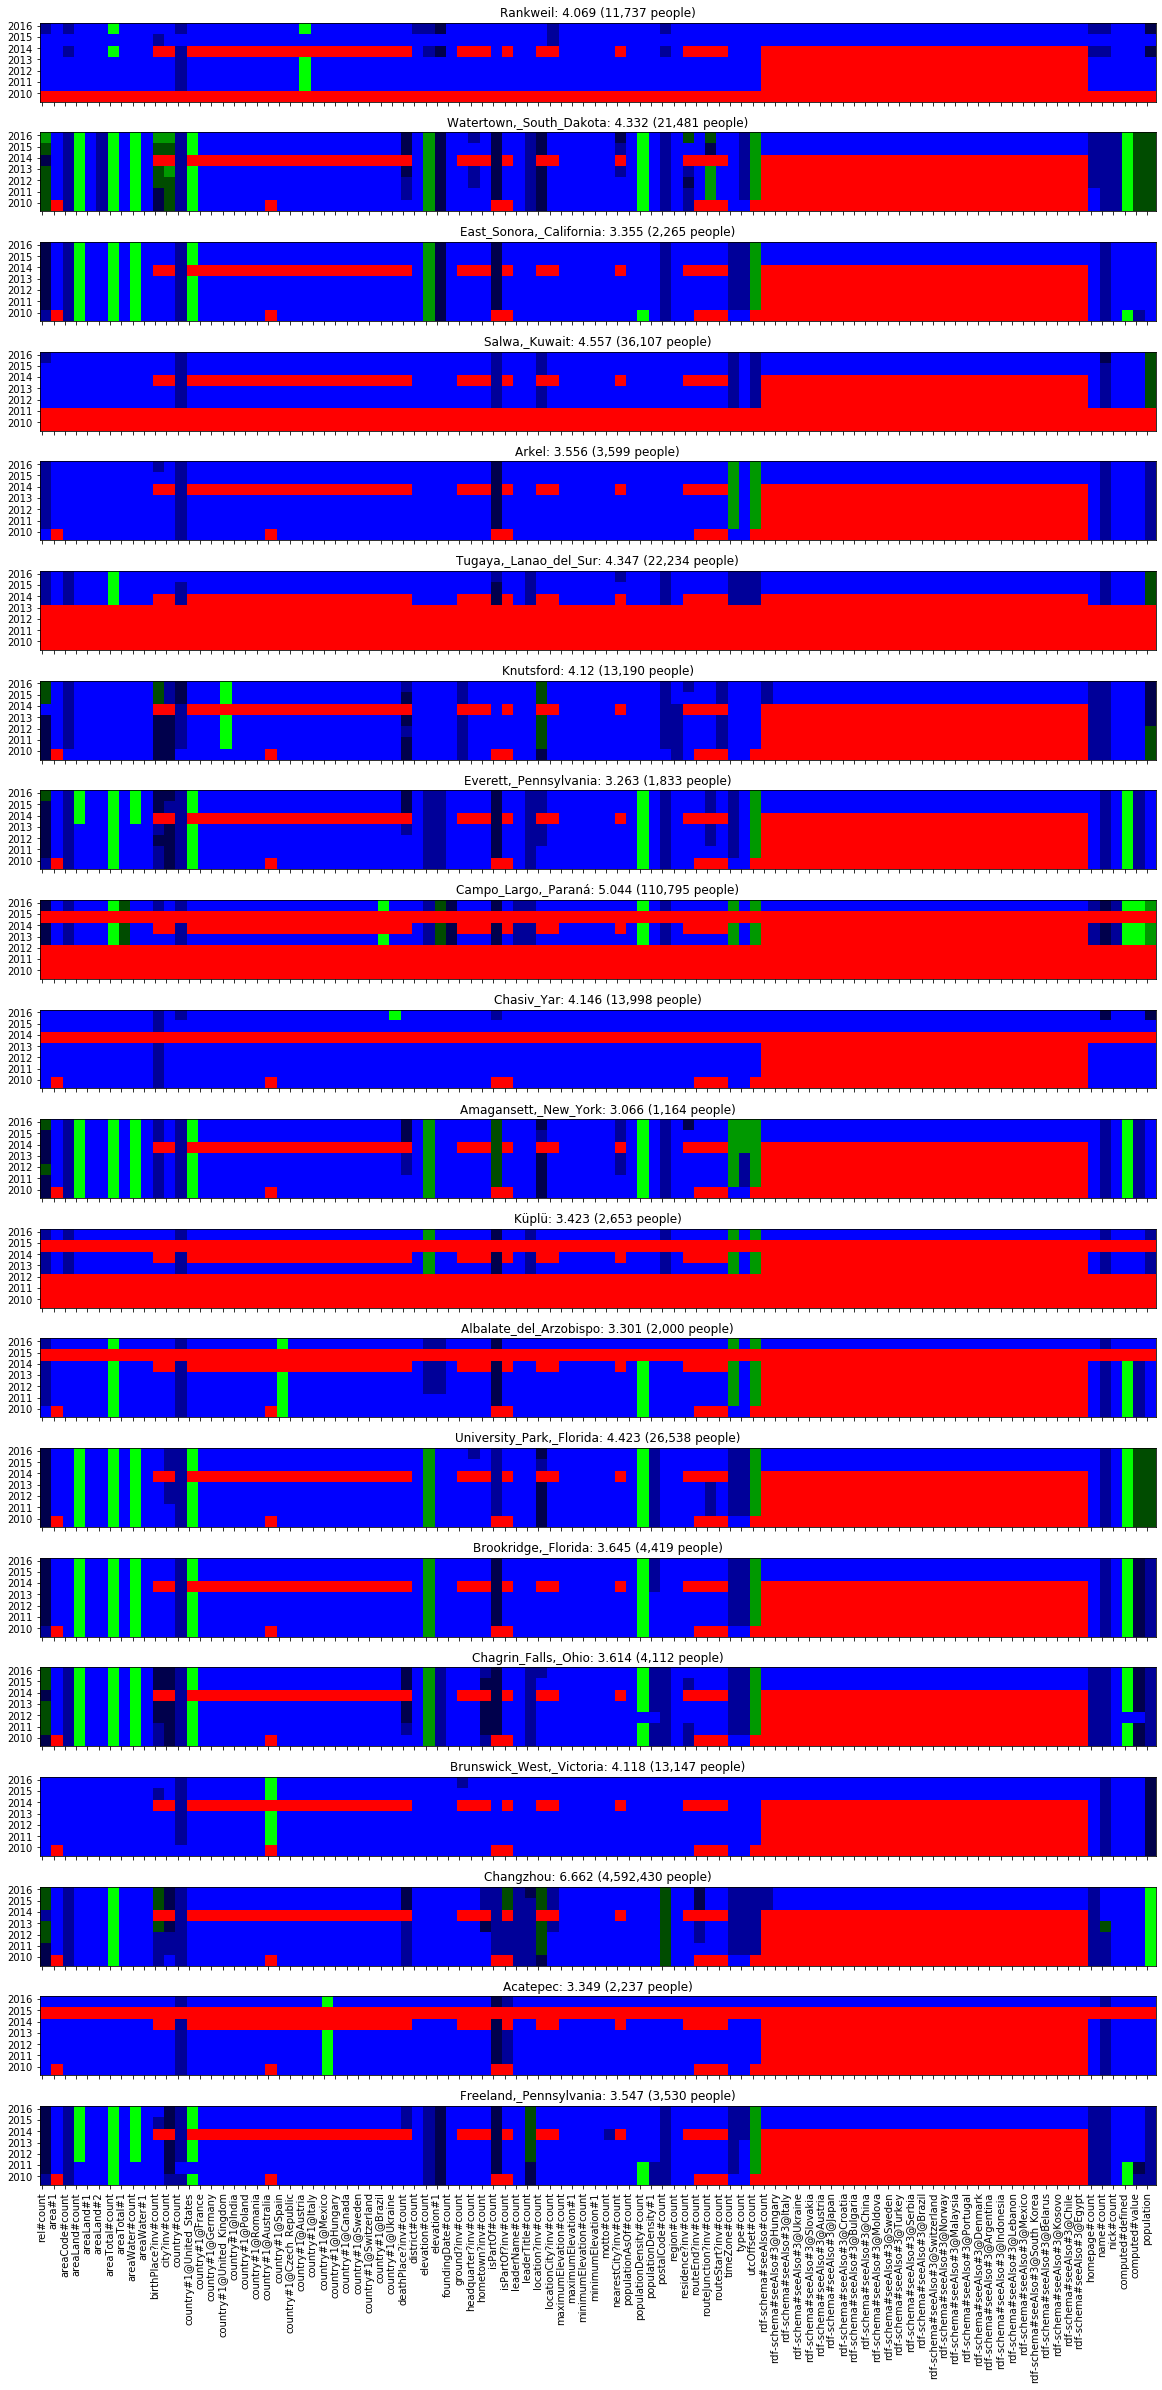

In [6]:
# CELL 6
import random
import math
import numpy as np
from sklearn.cluster import KMeans

rand = random.Random(42)

header = None
data = list()
with open("ch7_cell5_dev_missing.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        feats = list(map(float, fields[1:]))
        data.append( (feats, feats[-1], name) )

table = np.zeros( (len(data), len(header)) )
for idx, row in enumerate(data):
    table[idx] = row[0]

base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

# compute boundaries using kMeans
boundaries = list()
for feat in range(FEATS):
    col = table[:,2*VERSIONS*FEATS + feat]
    vals = set(col)
    num_clusters = min(len(vals), 6)
    if num_clusters < 6:
        boundaries.append(sorted(vals))
    else:
        kmeans = KMeans(n_clusters=6, random_state=1).fit(col.reshape(-1,1))
        boundaries.append(sorted(set(list(kmeans.cluster_centers_.reshape(-1)))))

# pick some cities at random to graph
to_show = rand.sample(list(range(len(data))), 20)

def colorize(feat, feat_val):
    num_classes = len(boundaries[feat])
    half_classes = num_classes // 2
    if half_classes == 0:
        half_classes = 1
    dists = sorted(map(lambda x: (abs(x[1]-feat_val), x[0]), enumerate(boundaries[feat])))
    clazz = dists[0][1]
    if clazz >= half_classes:
        component = 1
        clazz -= half_classes
    else:
        component = 2
        clazz = half_classes - clazz - 1
        
    intensity = None
    if clazz == 0:
        if half_classes == 3:
            intensity = 0.3
        elif half_classes == 2:
            intensity = 0.6
        elif half_classes == 1:
            intensity = 1.0
    elif clazz == 1:
        if half_classes == 3:
            intensity = 0.6
        elif half_classes == 2:
            intensity = 1.0
        elif half_classes == 1:
            intensity = 1.0
    elif clazz == 2:
        intensity = 1.0
    box_color = [ 0.0, 0.0, 0.0 ]
    box_color[component] = intensity
    #print(dists, clazz, num_classes, half_classes, box_color)
    return box_color

def gray(box_color):
    if box_color[0] == 1.0:
        col = 0.0
    elif box_color[1] == 0.0:
        col = box_color[2] / 2
    else:
        col = 0.5 + box_color[1] / 2
    return [ col, col, col ]

HEIGHT=2
WIDTH=2

def shrink_name(feat_name):
    if '@' in feat_name:
        parts = feat_name.split('@')
        return parts[0].split("/")[-1] + "@" + parts[1].split("/")[-1][:-1]
    else:
        if '/' in feat_name:
            return feat_name.split("/")[-1]
    return feat_name

img = np.zeros( [ (VERSIONS + 1) * HEIGHT, FEATS * WIDTH, 3 ])
img[:,:,:] = 1.0

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 40]

plt.axis('on')
yticks_locs = list(map(lambda x:x*HEIGHT, range(VERSIONS+1))) 
yticks_labels = list(map(lambda x:2016-x, range(VERSIONS+1))) 
xticks_locs = list(map(lambda x:x*WIDTH, range(FEATS)))
xticks_labels = list(map(lambda x:shrink_name(x), base_features))
plt.yticks(yticks_locs, yticks_labels)
plt.xticks(xticks_locs, xticks_labels, rotation=90)

idx = list(filter(lambda x:x[1][-1].endswith("Mérida,_Yucatán>"), enumerate(data)))[0][0]
xbox = 0
for feat in range(FEATS):
    ybox = feat * WIDTH
    img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = gray(colorize(feat, 
                                                                      table[idx, 2 * VERSIONS * FEATS + feat]))
for version in range(VERSIONS):
    xbox = (VERSIONS - version) * HEIGHT
    for feat in range(FEATS):
        ybox = feat * WIDTH
        box_color = gray(colorize(feat, table[idx, 2 * version * FEATS + 2 * feat + 1]))
        # mark imputation
        if table[idx,  2 * FEATS * version + 2 * feat] == 0.0:
            img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = [ 1.0, 1.0, 1.0 ]
            img[ xbox + 1, ybox ] = [ 0.0, 0.0, 0.0 ]
            img[ xbox, ybox + 1 ] = [ 0.0, 0.0, 0.0 ]
        else:
            img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = box_color 
print("{}: {} ({:,} people)".format(data[idx][-1].split("/")[-1][:-1],
                                               int(data[idx][1]*1000)/1000.0,
                                               int(10**data[idx][1])))
plt.imshow(img, aspect='equal')
plt.savefig("ch7_cell6_viz.pdf", bbox_inches='tight', dpi=300)


from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 40]

plt.axis('on')
for img_idx, idx in enumerate(to_show):
    plt.subplot(len(to_show), 1, img_idx + 1)
    plt.title("{}: {} ({:,} people)".format(data[idx][-1].split("/")[-1][:-1],
                                               int(data[idx][1]*1000)/1000.0,
                                               int(10**data[idx][1])))
    img = np.zeros( [ (VERSIONS + 1) * HEIGHT, FEATS * WIDTH, 3 ])
    img[:,:,:] = 1.0

    xbox = 0
    for feat in range(FEATS):
        ybox = feat * WIDTH
        img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = colorize(feat, 
                                                                     table[idx, 2 * VERSIONS * FEATS + feat]) 
    for version in range(VERSIONS):
        xbox = (VERSIONS - version) * HEIGHT
        for feat in range(FEATS):
            ybox = feat * WIDTH
            box_color = colorize(feat, table[idx, 2 * version * FEATS + 2 * feat + 1])
            # mark imputation
            if table[idx,  2 * FEATS * version + 2 * feat] == 0.0:
                img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = [1.0, 0, 0 ]
            else:
                img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = box_color 
    plt.imshow(img, aspect='equal')
    plt.yticks(yticks_locs, yticks_labels)
    plt.xticks(xticks_locs, [] if img_idx < len(to_show) - 1 else xticks_labels, rotation=90)
plt.savefig("ch7_cell6_viz_full.pdf", bbox_inches='tight', dpi=300)

From the figure we can see that the relation counts change from version to version but the target population seem to stay within the same range. There are plenty of missing features and the colours indicate a relative growth over time.

The "seeAlso" features are missing for all years, that's a big loss.

## First featurization: time lagged features

Given the large percentage of cities that are not present in all years, we will need a way to impute them.

### Imputation

I will use the closer available year, given priority to earlier years (Cell #7).

In [7]:
# CELL 7
import random
import math
import numpy as np

rand = random.Random(42)

header = None
data = list()
# load data
with open("ch7_cell5_dev_missing.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        feats = list(map(float, fields[1:]))
        data.append( (feats, feats[-1], name) )

table = np.zeros( (len(data), len(header)) )
for idx, row in enumerate(data):
    table[idx] = row[0]
    
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

# impute
back_imputed = 0
forward_imputed = 0
present_imputed = 0
for city_idx in range(CITIES):
    for version in range(VERSIONS):
        for feat in range(FEATS):
            if table[city_idx,  2 * FEATS * version + 2 * feat] == 1.0:
                continue
            lag = 1
            imputed = False
            while version + lag <= VERSIONS or version - lag >= 0:
                if version - lag >= 0 and table[city_idx,  2 * FEATS * (version - lag) + 2 * feat] == 1.0:
                    table[city_idx,  2 * FEATS * version + 2 * feat + 1] = \
                      table[city_idx,  2 * FEATS * (version - lag) + 2 * feat + 1]
                    back_imputed += 1
                    imputed = True
                    break
                if version + lag < VERSIONS and table[city_idx,  2 * FEATS * (version + lag) + 2 * feat] == 1.0:
                    table[city_idx,  2 * FEATS * version + 2 * feat + 1] = \
                      table[city_idx,  2 * FEATS * (version + lag) + 2 * feat + 1]
                    forward_imputed += 1
                    imputed = True
                    break
                if version + lag == VERSIONS: # present
                    table[city_idx,  2 * FEATS * version + 2 * feat + 1] = \
                      table[city_idx,  2 * FEATS * (version + lag) + feat]
                    present_imputed += 1
                    imputed = True
                    break
                lag += 1
            if not imputed:
                print(version, feat, data[city_idx][-1])

# write full feature table
imputed_cells = 0
total_cells = 0
with open("ch7_cell7_dev_imputed.tsv", "w") as w:
    w.write('name')
    w.write('\t' + '\t'.join(header) + "\n")
    for city_idx, city in enumerate(map(lambda x:x[-1], data)):
        total_cells += FEATS * VERSIONS
        w.write(city)
        w.write('\t' + '\t'.join(map(str, table[city_idx,:])))
        w.write('\n')
imputed_cells = back_imputed + forward_imputed + present_imputed
print("Total cells: {:,} imputed: {:,} ({:%})".format(total_cells, imputed_cells, imputed_cells / total_cells))
print("Backward imputed: {:,} ({:%})".format(back_imputed, back_imputed / imputed_cells))
print("Forward imputed: {:,} ({:%})".format(forward_imputed, forward_imputed / imputed_cells))
print("Present imputed: {:,} ({:%})".format(present_imputed, present_imputed / imputed_cells))

Total cells: 26,705,646 imputed: 11,078,309 (41.483022%)
Backward imputed: 1,770,176 (15.978756%)
Forward imputed: 7,154,111 (64.577644%)
Present imputed: 2,154,022 (19.443599%)


So most features are not present-imputed. That is important because otherwise there will be little value of the historical features. 

Let us visualize this (Cell #8).

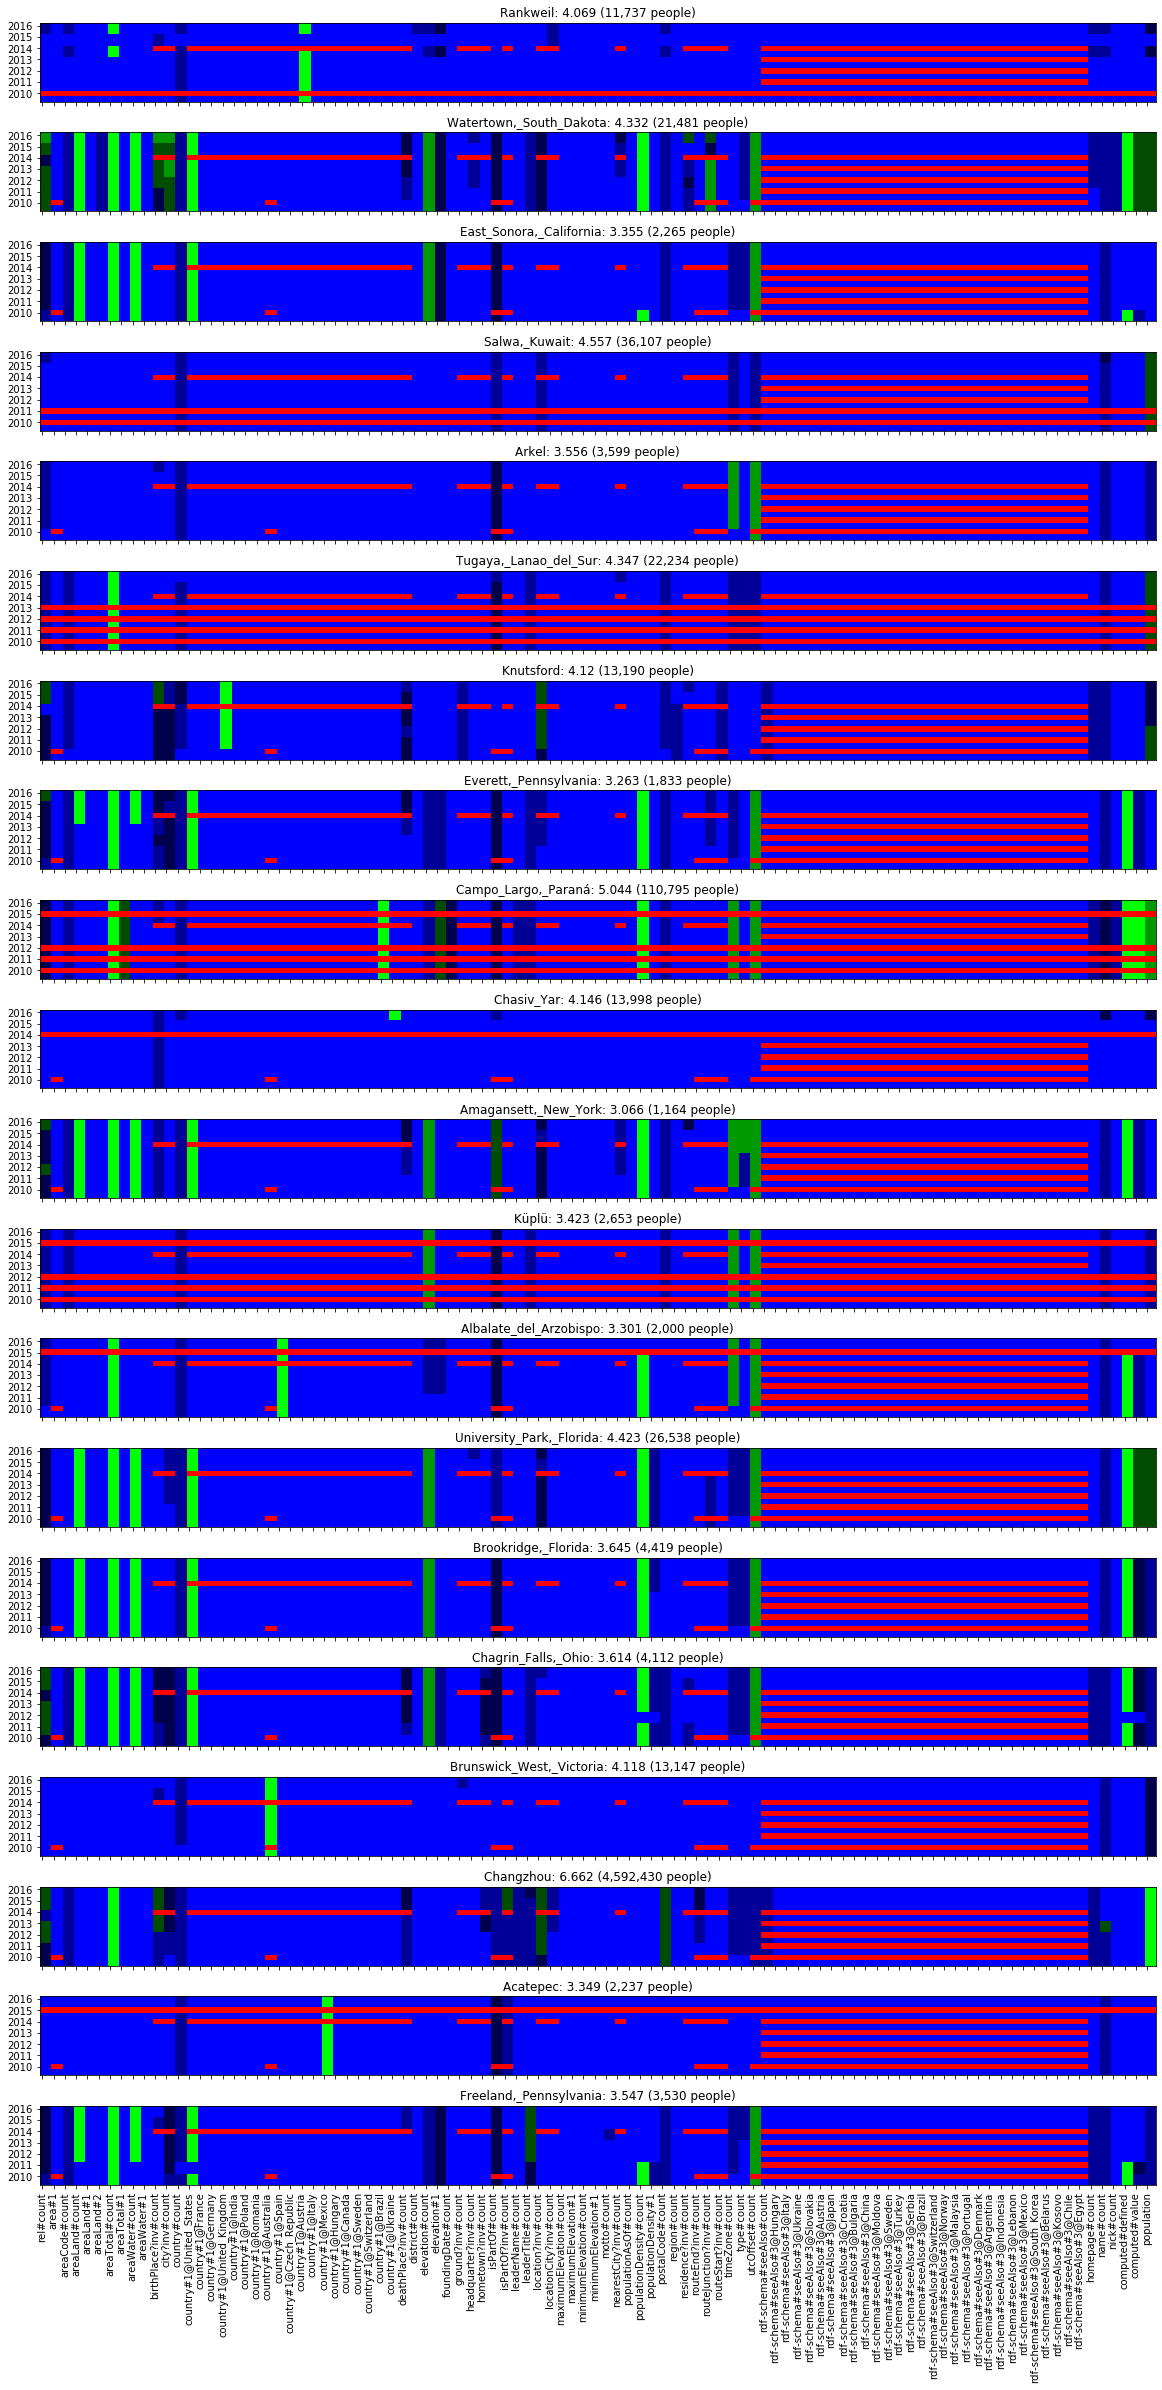

In [8]:
# CELL 8
import random
import math
import numpy as np
from sklearn.cluster import KMeans

rand = random.Random(42)

header = None
data = list()
with open("ch7_cell7_dev_imputed.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        feats = list(map(float, fields[1:]))
        data.append( (feats, feats[-1], name) )

table = np.zeros( (len(data), len(header)) )
for idx, row in enumerate(data):
    table[idx] = row[0]

base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

# compute boundaries using kMeans
boundaries = list()
for feat in range(FEATS):
    col = table[:,2*VERSIONS*FEATS + feat]
    vals = set(col)
    num_clusters = min(len(vals), 6)
    if num_clusters < 6:
        boundaries.append(sorted(vals))
    else:
        kmeans = KMeans(n_clusters=6, random_state=1).fit(col.reshape(-1,1))
        boundaries.append(sorted(set(list(kmeans.cluster_centers_.reshape(-1)))))
        
# save boundaries
with open("ch7_cell8_boundaries.tsv", "w") as b:
    for idx, boundary_list in enumerate(boundaries):
        b.write("{}\t{}\n".format(idx, "\t".join(map(str,boundary_list))))

# pick some cities at random to graph
to_show = rand.sample(list(range(len(data))), 20)

def cell8_colorize(feat, feat_val, boundaries):
    num_classes = len(boundaries[feat])
    half_classes = num_classes // 2
    if half_classes == 0:
        half_classes = 1
    dists = sorted(map(lambda x: (abs(x[1]-feat_val), x[0]), enumerate(boundaries[feat])))
    clazz = dists[0][1]
    if clazz >= half_classes:
        component = 1
        clazz -= half_classes
    else:
        component = 2
        clazz = half_classes - clazz - 1
        
    intensity = None
    if clazz == 0:
        if half_classes == 3:
            intensity = 0.3
        elif half_classes == 2:
            intensity = 0.6
        elif half_classes == 1:
            intensity = 1.0
    elif clazz == 1:
        if half_classes == 3:
            intensity = 0.6
        elif half_classes == 2:
            intensity = 1.0
        elif half_classes == 1:
            intensity = 1.0
    elif clazz == 2:
        intensity = 1.0
    box_color = [ 0.0, 0.0, 0.0 ]
    box_color[component] = intensity
    #print(dists, clazz, num_classes, half_classes, box_color)
    return box_color

HEIGHT=2
WIDTH=2

def cell8_shrink_name(feat_name):
    if '@' in feat_name:
        parts = feat_name.split('@')
        return parts[0].split("/")[-1] + "@" + parts[1].split("/")[-1][:-1]
    else:
        if '/' in feat_name:
            return feat_name.split("/")[-1]
    return feat_name

img = np.zeros( [ (VERSIONS + 1) * HEIGHT, FEATS * WIDTH, 3 ])
img[:,:,:] = 1.0


yticks_locs = list(map(lambda x:x*HEIGHT, range(VERSIONS+1))) 
yticks_labels = list(map(lambda x:2016-x, range(VERSIONS+1))) 
xticks_locs = list(map(lambda x:x*WIDTH, range(FEATS)))
xticks_labels = list(map(lambda x:cell8_shrink_name(x), base_features))

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 40]

def cell8_draw_features(plot, row, title, versions, boundaries,
                        yticks_locs, yticks_labels, xticks_locs, xticks_labels):
    if title is not None:
        plot.title(title)
    img = np.zeros( [ (versions + 1) * HEIGHT, FEATS * WIDTH, 3 ])
    img[:,:,:] = 1.0

    xbox = 0
    for feat in range(FEATS):
        ybox = feat * WIDTH
        img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = \
           cell8_colorize(feat, row[2 * versions * FEATS + feat], boundaries) 
    for version in range(versions):
        xbox = (versions - version) * HEIGHT
        for feat in range(FEATS):
            ybox = feat * WIDTH
            box_color = cell8_colorize(feat, row[2 * version * FEATS + 2 * feat + 1], boundaries)
            # mark imputation
            if row[2 * FEATS * version + 2 * feat] == 0.0:
                img[ xbox:(xbox + HEIGHT // 2), ybox: (ybox + WIDTH) ] = [1.0, 0, 0 ]
                img[ (xbox + HEIGHT // 2):(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = box_color
            else:
                img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = box_color 
    plot.imshow(img, aspect='equal')
    plot.yticks(yticks_locs, yticks_labels)
    plot.xticks(xticks_locs, xticks_labels, rotation=90)    

plt.axis('on')
for img_idx, idx in enumerate(to_show):
    plt.subplot(len(to_show), 1, img_idx + 1)
    cell8_draw_features(plt, table[idx,:], "{}: {} ({:,} people)".format(data[idx][-1].split("/")[-1][:-1],
                                            int(table[idx,-1]*1000)/1000.0,
                                            int(10**table[idx,-1])), 
                        VERSIONS, boundaries, 
                        yticks_locs, yticks_labels, xticks_locs, 
                        [] if img_idx < len(to_show) - 1 else xticks_labels)

plt.savefig("ch7_cell8_viz_full.pdf", bbox_inches='tight', dpi=300)

The imputation looks like it completes quite well the values. Watertown seems to have some surprises in the center. We are now ready for the first featurization.

For the first featurization, I will add the historical version of each feature, for the last two versions (Cell #9). Due to the large number of features, I will switch to RFs.

Features: 490
Training on 35,971 cities
RMSE 0.3539960933029513
Writing files for error analysis


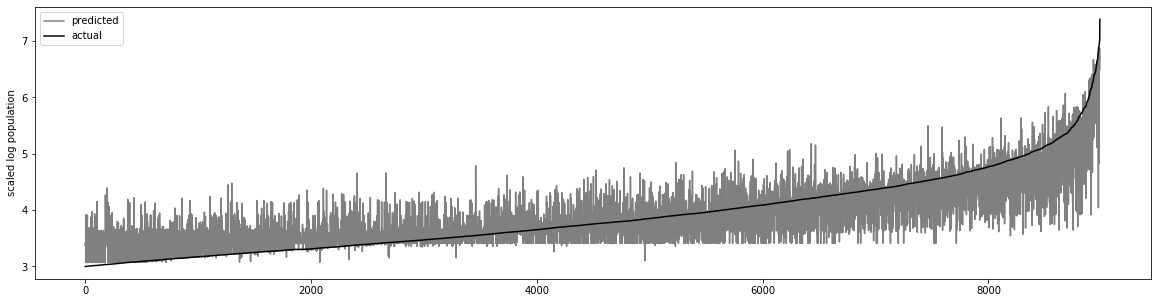

In [9]:
# CELL 9
import random
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rand = random.Random(42)

header = None
data = list()
with open("ch7_cell7_dev_imputed.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)
        
# assemble train/test for a given lag        
PARAM_LAG = 2

train_data = list()
test_data = list()

print("Features: {:,}".format(FEATS * PARAM_LAG * 2 + FEATS))
full_header = header
header = list()
for lag in range(PARAM_LAG):
    header.extend(full_header[2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
header.extend(full_header[2*VERSIONS*FEATS:])

for full_row in data:
    feats = list()
    for lag in range(PARAM_LAG):
        feats.extend(full_row[0][2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
    feats.extend(full_row[0][2*VERSIONS*FEATS:])
    row = (feats, full_row[1], full_row[-1])
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)

# write feature set
with open("ch7_cell9_dev_feat1.tsv", "w") as w:
    w.write('name\t' + '\t'.join(header) + '\tpopulation\n')
    all_data = list(train_data)
    all_data.extend(test_data)
    for row in all_data:
        w.write("{}\t{}\t{}\n".format(row[-1], '\t'.join(map(str, row[0])), row[1]))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# train
print("Training on {:,} cities".format(len(xtrain)))

rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rfr.fit(xtrain, ytrain)
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed("ch7_cell9_feat1_rf.npz", 
                    xtrain=xtrain, ytrain=ytrain,
                    xtest=xtest, ytest=ytest,
                    ytest_pred=ytest_pred)
import pickle
with open("ch7_cell9_model.pk", "wb") as pkl:
    pickle.dump(rfr, pkl)
with open("ch7_cell9_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))
rfr=None # free memory

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch7_cell9_rf_feat1.pdf", bbox_inches='tight', dpi=300)
plt.legend()

So this does barely improves over the SVR baseline (0.3578). Let us see the RMSE for using other lags in Cell #10.

In [10]:
# CELL 10
import random
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

header = None
data = list()
with open("ch7_cell7_dev_imputed.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

for lag in range(0, VERSIONS):
    train_data = list()
    test_data = list()
    
    rand = random.Random(42)
    for full_row in data:
        feats = list()
        for l in range(lag):
            feats.extend(full_row[0][2*(VERSIONS-l-1)*FEATS: 2*(VERSIONS-l)*FEATS])
        feats.extend(full_row[0][2*VERSIONS*FEATS:])
        row = (feats, full_row[1], full_row[-1])
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
    test_data = sorted(test_data, key=lambda t:t[1])
    test_names = list(map(lambda t:t[2], test_data))

    xtrain = np.array(list(map(lambda t:t[0], train_data)))
    ytrain = np.array(list(map(lambda t:t[1], train_data)))
    xtest = np.array(list(map(lambda t:t[0], test_data)))
    ytest = np.array(list(map(lambda t:t[1], test_data)))

    # train
    rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
    rfr.fit(xtrain, ytrain)
    ytest_pred = rfr.predict(xtest)
    RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
    print("Lag: {}, Features: {:4d}, RMSE RF: {}".format(lag, FEATS * lag * 2 + FEATS, RMSE))
    rfr=None # free memory

Lag: 0, Features:   98, RMSE RF: 0.35944769738144156
Lag: 1, Features:  294, RMSE RF: 0.35512799575351456
Lag: 2, Features:  490, RMSE RF: 0.35399609330295134
Lag: 3, Features:  686, RMSE RF: 0.35392127313759164
Lag: 4, Features:  882, RMSE RF: 0.3542685277009543
Lag: 5, Features: 1078, RMSE RF: 0.35400003180280026


Before doing Error Analysis, let's look at computing differences (Cell #11).

In [11]:
# CELL 11
import random
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

header = None
data = list()
with open("ch7_cell7_dev_imputed.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

for lag in range(0, VERSIONS):
    train_data = list()
    test_data = list()
    
    rand = random.Random(42)
    for full_row in data:
        feats = list()
        for l in range(lag):
            for feat in range(FEATS):
                feats.append(full_row[0][2*VERSIONS*FEATS+feat] - full_row[0][2*(VERSIONS-l-1)*FEATS+2*feat+1])
        feats.extend(full_row[0][2*VERSIONS*FEATS:])
        row = (feats, full_row[1], full_row[-1])
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
    test_data = sorted(test_data, key=lambda t:t[1])
    test_names = list(map(lambda t:t[2], test_data))

    xtrain = np.array(list(map(lambda t:t[0], train_data)))
    ytrain = np.array(list(map(lambda t:t[1], train_data)))
    xtest = np.array(list(map(lambda t:t[0], test_data)))
    ytest = np.array(list(map(lambda t:t[1], test_data)))

    # train
    rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
    rfr.fit(xtrain, ytrain)
    ytest_pred = rfr.predict(xtest)
    RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
    print("Lag: {}, Features: {:4d}, RMSE RF: {}".format(lag, FEATS * lag * 2 + FEATS, RMSE))
    rfr=None # free memory

Lag: 0, Features:   98, RMSE RF: 0.3594476973814416
Lag: 1, Features:  294, RMSE RF: 0.35994266636334954
Lag: 2, Features:  490, RMSE RF: 0.35881072923353247
Lag: 3, Features:  686, RMSE RF: 0.3588757551525587
Lag: 4, Features:  882, RMSE RF: 0.35841226499154577
Lag: 5, Features: 1078, RMSE RF: 0.3583744135420653


The absolute differences might be a problem and scaling the differences will not work either as many features are zero. Let us drill down.


## Error Analysis

I'll use the feature heatmaps to see which cities did worse with the lags than without them (Cell #12).

RMSE lag 2: 0.3539960933029513, RMSE base: 0.35944769738144156


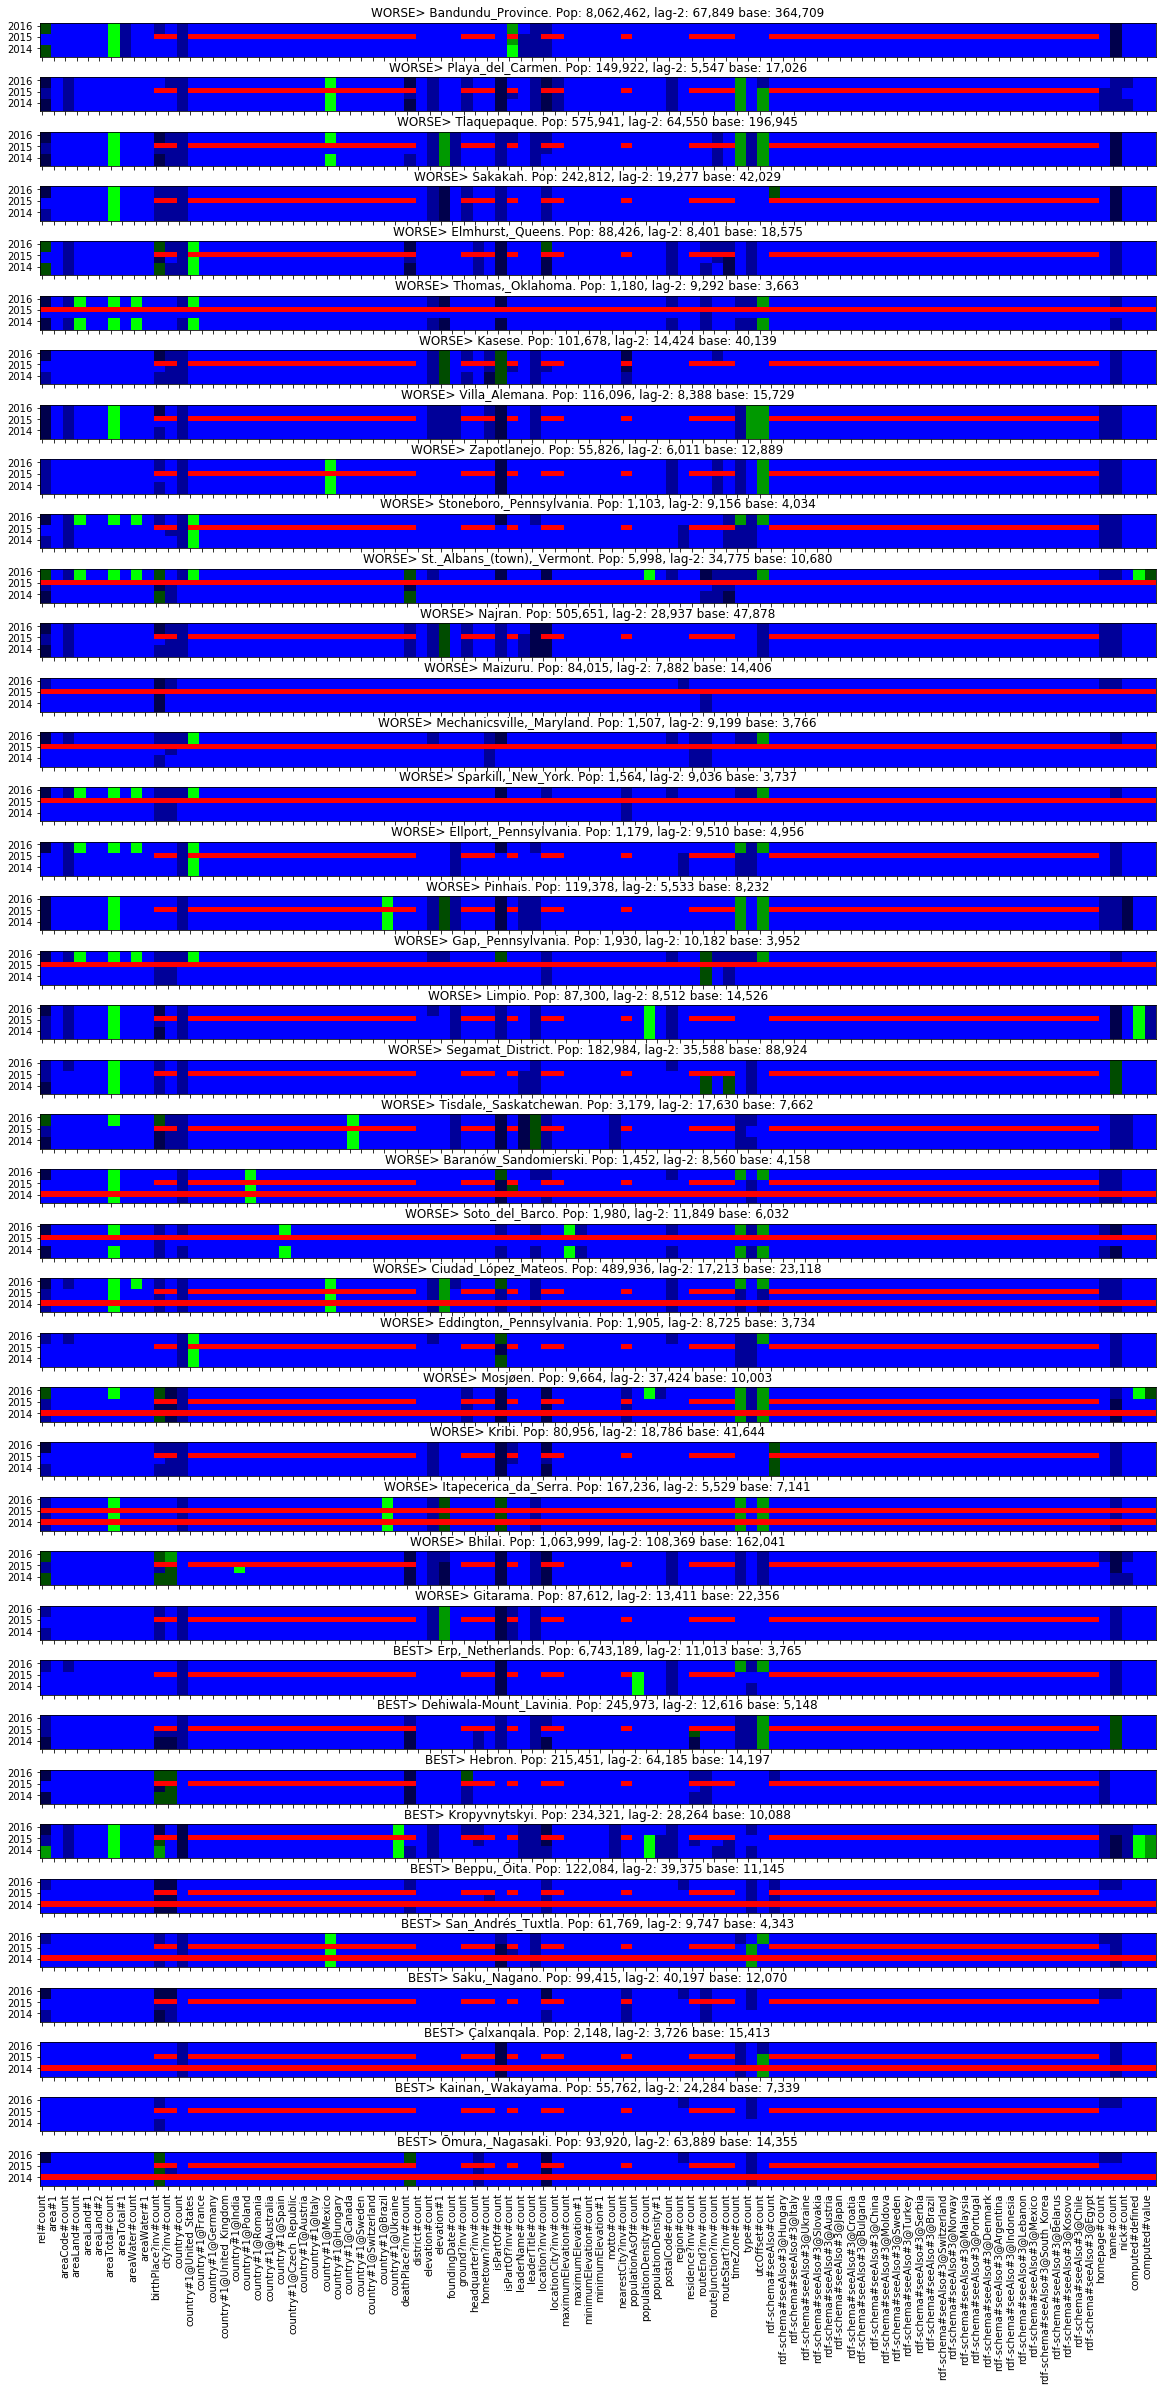

In [12]:
# CELL 12
import random
import math
import pickle
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# load
arrays = np.load("ch7_cell9_feat1_rf.npz")
xtrain = arrays['xtrain']
ytrain = arrays['ytrain']
xtest = arrays['xtest']
ytest = arrays['ytest']
ytest_pred = arrays['ytest_pred']

with open("ch7_cell9_dev_feat1.tsv") as f:
    header = next(f).split('\t')
    del header[0] # name
    header.pop() # pop

base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
LAGS = 2

test_names = list()
with open("ch7_cell9_test_names.tsv") as names:
    for line in names:
        test_names.append(line.split("\t")[-1])

# train on base features only
xtrain_base = xtrain[:,2*LAGS*FEATS:]
xtest_base = xtest[:,2*LAGS*FEATS:]
rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rfr.fit(xtrain_base, ytrain)
ytest_pred_base = rfr.predict(xtest_base)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
RMSE_base = math.sqrt(sum((ytest - ytest_pred_base)**2) / len(ytest))
print("RMSE lag 2: {}, RMSE base: {}".format(RMSE, RMSE_base))
rfr=None # free memory

# find 10 cities where it helped them most and 10 cities where it hurt the most
sqe_lag2 = (ytest - ytest_pred) ** 2
sqe_base = (ytest - ytest_pred_base) ** 2

diff = sqe_base - sqe_lag2
idx_diff = sorted(list(zip(diff, range(len(diff)))))
    
# visualize
boundaries = list()
with open("ch7_cell8_boundaries.tsv") as b:
    for line in b:
        boundaries.append(list(map(float, line.split("\t")[1:])))

yticks_locs = list(map(lambda x:x*HEIGHT, range(LAGS+1))) 
yticks_labels = list(map(lambda x:2016-x, range(LAGS+1))) 
xticks_locs = list(map(lambda x:x*WIDTH, range(FEATS)))
xticks_labels = list(map(lambda x:cell8_shrink_name(x), base_features))

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 40]
plt.axis('on')
for idx in range(30):
    city_idx = idx_diff[idx][1]
    plt.subplot(40, 1, idx + 1)
    row = list(xtest[city_idx,:])
    row.append(ytest[city_idx])
    cell8_draw_features(plt, row, 
                        "WORSE> {}. Pop: {:,}, lag-2: {:,} base: {:,}"
                           .format(test_names[city_idx].strip().split("/")[-1][:-1],
                                   int(10**row[-1]), int(10**ytest_pred[city_idx]), 
                                   int(10**ytest_pred_base[city_idx])),
                        LAGS, boundaries, yticks_locs, yticks_labels, xticks_locs, [])
for idx in range(10):
    city_idx = idx_diff[len(idx_diff) - idx - 1][1]
    plt.subplot(40, 1, 30 + idx + 1)
    row = list(xtest[city_idx,:])
    row.append(ytest[city_idx])
    cell8_draw_features(plt, row, 
                        "BEST> {}. Pop: {:,}, lag-2: {:,} base: {:,}"
                           .format(test_names[city_idx].strip().split("/")[-1][:-1],
                                   int(10**row[-1]), int(10**ytest_pred[city_idx]), 
                                   int(10**ytest_pred_base[city_idx])),
                        LAGS, boundaries, yticks_locs, yticks_labels, xticks_locs, 
                        [] if idx < 9 else xticks_labels)

plt.savefig("ch7_cell12_viz_full.pdf", bbox_inches='tight', dpi=300)

From the error analysis, it seems regressions on the first column might be problem. Smoothing that behaviour could work. 

## Second Featurization

Let's start with a simple moving average (Cell #13).

In [13]:
# CELL 13
import random
import math
import numpy as np
from sklearn.ensemble import RandomForestRegressor

rand = random.Random(42)

header = None
data = list()
with open("ch7_cell7_dev_imputed.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

table = np.zeros( (len(data), len(header)) )
for idx, row in enumerate(data):
    table[idx] = row[0]

# SMA
smoothing_square = 0
smoothed_cells = 0
for city_idx in range(CITIES):
    for feat in range(FEATS):
        sma = 0
        for version in range(3):
            sma += table[city_idx,  2 * FEATS * version + 2 * feat + 1] / 3.0
        for version in range(3, VERSIONS + 1):
            diff = table[city_idx,  2 * FEATS * (version - 1) + 2 * feat + 1] - sma
            smoothed_cells += 1
            smoothing_square += diff * diff
            table[city_idx,  2 * FEATS * (version - 1) + 2 * feat + 1] = sma
            if version < VERSIONS:
                sma -= table[city_idx,  2 * FEATS * (version - 3) + 2 * feat + 1] / 3.0
                sma += table[city_idx,  2 * FEATS * version + 2 * feat + 1] / 3.0

# write full feature table
with open("ch7_cell13_dev_sma.tsv", "w") as w:
    w.write('name\t' + '\t'.join(header[2*FEATS*2:]) + "\n")
    for city_idx, city in enumerate(map(lambda x:x[-1], data)):
        w.write(city + '\t' + '\t'.join(map(str, table[city_idx,2*FEATS*2:])) + '\n')
        
print("Smoothed {:,} cells, root mean squared smoothing: {:,}".format(
   smoothed_cells, math.sqrt(smoothing_square/smoothed_cells)))

Smoothed 17,803,764 cells, root mean squared smoothing: 871,544,520.7773069


That's... a lot of smoothing. Now let's try again with lag-2 over the SMA for the second featurization (Cell #14).

Features: 490
Training on 35,971 cities
RMSE 0.35805841568706775


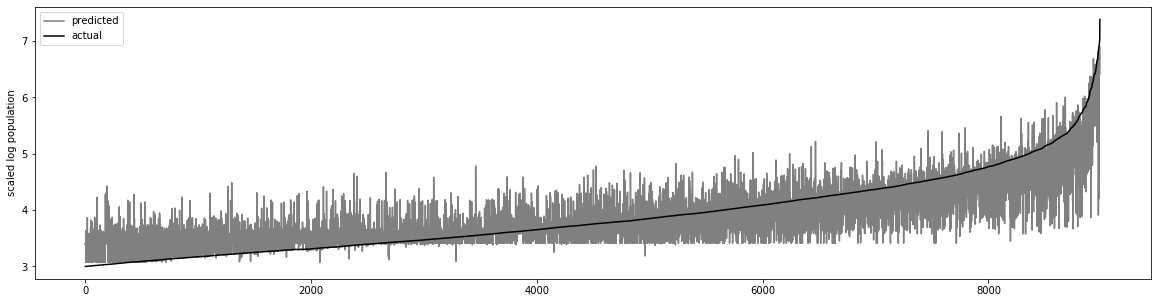

In [14]:
# CELL 14
import random
import math
import numpy as np

rand = random.Random(42)

header = None
data = list()
with open("ch7_cell13_dev_sma.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 4
CITIES = len(data)
        
# assemble train/test for a given lag        
PARAM_LAG = 2

train_data = list()
test_data = list()

print("Features: {:,}".format(FEATS * PARAM_LAG * 2 + FEATS))
full_header = header
header = list()
for lag in range(PARAM_LAG):
    header.extend(full_header[2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
header.extend(full_header[2*VERSIONS*FEATS:])

for full_row in data:
    feats = list()
    for lag in range(PARAM_LAG):
        feats.extend(full_row[0][2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
    feats.extend(full_row[0][2*VERSIONS*FEATS:])
    row = (feats, full_row[1], full_row[-1])
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)

# write feature set
with open("ch7_cell14_dev_feat2.tsv", "w") as w:
    w.write('name\t' + '\t'.join(header) + '\tpopulation\n')
    all_data = list(train_data)
    all_data.extend(test_data)
    for row in all_data:
        w.write("{}\t{}\t{}\n".format(row[-1], '\t'.join(map(str, row[0])), row[1]))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# train
print("Training on {:,} cities".format(len(xtrain)))

rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rfr.fit(xtrain, ytrain)
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)
rfr=None # free memory

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch7_cell14_rf_feat2.pdf", bbox_inches='tight', dpi=300)
plt.legend()

It got worse, which is not surprising given the level of smoothing. Let's try a different smoothing.

## Third Featurization

I will now use an exponential moving average from the present into the past, so I will combine smoothing with imputation (Cell #15).

In [15]:
# CELL 15
import random
import math
import numpy as np

header = None
data = list()
# load data
with open("ch7_cell5_dev_missing.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        feats = list(map(float, fields[1:]))
        data.append( (feats, feats[-1], name) )

table = np.zeros( (len(data), len(header)) )
for idx, row in enumerate(data):
    table[idx] = row[0]
    
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

# impute and EMA
PARAM_EMA_WEIGHT = 0.2 # history is worth 80%, strong smoothing

smoothing_square = 0
smoothed_cells = 0
missed_imputed = 0
for city_idx in range(CITIES):
    for feat in range(FEATS):
        ema = table[city_idx,  2 * FEATS * VERSIONS + feat] 
        for upversion in range(VERSIONS):
            version = VERSIONS - upversion - 1
            smoothed = ema
            if table[city_idx,  2 * FEATS * version + 2 * feat] == 1.0:
                value = table[city_idx,  2 * FEATS * version + 2 * feat + 1]
                smoothed = PARAM_EMA_WEIGHT * value + (1.0 - PARAM_EMA_WEIGHT) * ema 
                smoothed_cells += 1
                diff = value - smoothed
                smoothing_square += diff * diff
            else:
                missed_imputed += 1
            table[city_idx,  2 * FEATS * version + 2 * feat + 1] = smoothed
            ema = smoothed

# write full feature table
imputed_cells = 0
total_cells = 0
with open("ch7_cell15_dev_ema_imputed.tsv", "w") as w:
    w.write('name')
    w.write('\t' + '\t'.join(header) + "\n")
    for city_idx, city in enumerate(map(lambda x:x[-1], data)):
        w.write(city)
        w.write('\t' + '\t'.join(map(str, table[city_idx,:])))
        w.write('\n')
print("Total cells: {:,} missed imputed: {:,}".format(table.shape[0]*table.shape[1], missed_imputed))
print("Smoothed {:,} cells, root mean squared smoothing: {:,}".format(
   smoothed_cells, math.sqrt(smoothing_square/smoothed_cells)))

Total cells: 57,862,233 missed imputed: 11,078,309
Smoothed 15,627,337 cells, root mean squared smoothing: 4,243,407,341.0603514


And now with a lag-2 RF (Cell #16).

Features: 490
Training on 35,971 cities
RMSE 0.3550061299937911


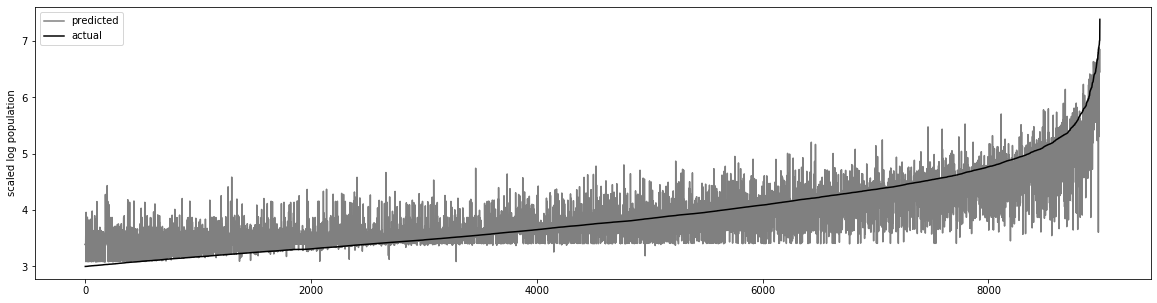

In [16]:
# CELL 16
import random
import math
import numpy as np

rand = random.Random(42)

header = None
data = list()
with open("ch7_cell15_dev_ema_imputed.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS    = len(base_features)
VERSIONS = 6
CITIES   = len(data)

# assemble train/test for a given lag        
PARAM_LAG = 2

train_data = list()
test_data  = list()

print("Features: {:,}".format(FEATS * PARAM_LAG * 2 + FEATS))
full_header = header
header = list()
for lag in range(PARAM_LAG):
    header.extend(full_header[2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
header.extend(full_header[2*VERSIONS*FEATS:])

for full_row in data:
    feats = list()
    for lag in range(PARAM_LAG):
        feats.extend(full_row[0][2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
    feats.extend(full_row[0][2*VERSIONS*FEATS:])
    row = (feats, full_row[1], full_row[-1])
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)

# write feature set
with open("ch7_cell16_dev_feat3.tsv", "w") as w:
    w.write('name\t' + '\t'.join(header) + '\tpopulation\n')
    all_data = list(train_data)
    all_data.extend(test_data)
    for row in all_data:
        w.write("{}\t{}\t{}\n".format(row[-1], '\t'.join(map(str, row[0])), row[1]))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))

# train
print("Training on {:,} cities".format(len(xtrain)))

rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rfr.fit(xtrain, ytrain)
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)
rfr = None # free memory

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch7_cell16_rf_feat3.pdf", bbox_inches='tight', dpi=300)
plt.legend()

This improve a tiny bit, but it seems there is no value in the time dimension for this data set.

## Fourth Featurization

Finally, let's try using the extra rows as more training data (Cell #17).

Features: 98
Training on 251,797 cities
RMSE 0.372269900642798


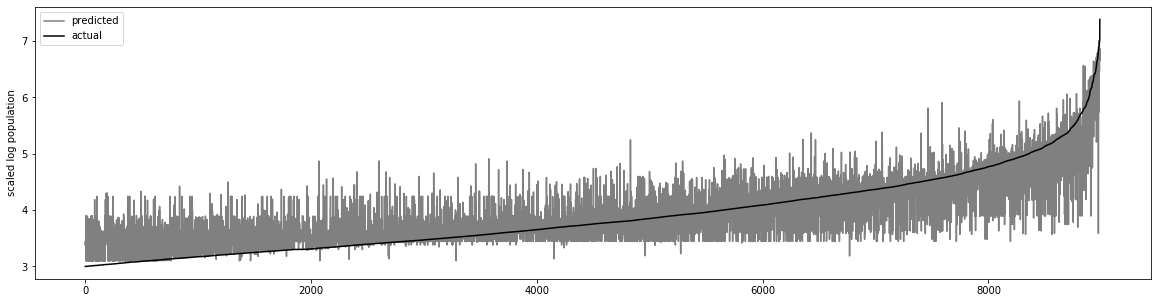

In [17]:
# CELL 17
import random
import math
import numpy as np

from sklearn.ensemble import RandomForestRegressor

rand = random.Random(42)

header = None
data = list()
with open("ch7_cell7_dev_imputed.tsv") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS    = len(base_features)
VERSIONS = 6
CITIES   = len(data)

full_train_data = list()
full_test_data  = list()

print("Features: {:,}".format(FEATS))

# stratify
for row in data:
    if rand.random() < 0.2:
        full_test_data.append(row) 
    else:
        full_train_data.append(row)
        
train_data = list()
test_data = list()
for row in full_train_data:
    feats = row[0]
    # current
    train_data.append( (feats[2*FEATS*VERSIONS:], row[1], row[2]) )
    for version in range(VERSIONS):
        historical_feats = list()
        for feat in range(FEATS):
            if feats[2 * FEATS * version + 2 * feat] == 1.0:
                historical_feats.append(feats[2 * FEATS * version + 2 * feat + 1])
            else: # use current instead of imputed
                historical_feats.append(feats[2 * FEATS * VERSIONS + feat])
        # historical
        train_data.append( (historical_feats, row[1], row[2]) )

for row in full_test_data:
    # test only on current
    test_data.append( (row[0][2*FEATS*VERSIONS:], row[1], row[2]) )
    
# write feature set
with open("ch7_cell17_dev_feat4.tsv", "w") as w:
    w.write('name\t' + '\t'.join(header[-98:]) + '\tpopulation\n')
    all_data = list(train_data)
    all_data.extend(test_data)
    for row in all_data:
        w.write("{}\t{}\t{}\n".format(row[-1], '\t'.join(map(str, row[0])), row[1]))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))

# train
print("Training on {:,} cities".format(len(xtrain)))

rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rfr.fit(xtrain, ytrain)
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)
rfr = None # free memory

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch7_cell17_rf_feat4.pdf", bbox_inches='tight', dpi=300)
plt.legend()

That increased the available training material five-fold (from 35,000 to 25,000). However, things got much worse.

At this stage, I'll conclude the exercise, things left to try by the reader:

* Use the target population of the historical version instead of the current population
* Use an imputed version of the feature (e.g., the EMA version) instead of the current version
* Drop rows with too many imputed values
* Drop columns with too many imputed values

With the current experimental results I wouldn't advise to use the historical data for this task. If I am forced to pick a high performance feature set, it will be the imputed version using lag-5. A conservative feature set would be just adding the EMA-smoothing for historical relation counts (and nothing else).


# WikiCountries

Let us start by identifying all entities of type http://dbpedia.org/ontology/Country (Cell #18).

In [18]:
# CELL 18
import re
import bz2

cell18_triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

def cell18_compressed_triples_gen(filename):
    with bz2.BZ2File(filename,"r") as compressed:
        for byteline in compressed:
            if byteline[0] == ord('#'):
                continue
            line = byteline.decode("utf-8")
            s,v,o = cell18_triple_re.match(line).groups()
            yield line,s,v,o

total_countries = 0
with open("ch7_cell18_countries.ttl", "w") as countries:
    for line, subj, verb, obj in cell18_compressed_triples_gen("instance_types_en.ttl.bz2"):
        if obj == '<http://dbpedia.org/ontology/Country>':
            countries.write(line)
            total_countries += 1
print("Found {:,} entities of type Country".format(total_countries))

Found 3,424 entities of type Country


As there are an order of magnitude less countries than 3,424 that clearly count many, many historical and fictional countries.

Now let's transform the source data from the World Bank into a TSV (Cell #19).

In [19]:
# CELL 19
import csv
rows = list()
with open("API_SP.POP.TOTL_DS2_en_csv_v2_10224786.csv") as wb:
    dialect = csv.Sniffer().sniff(wb.read(1024))
    wb.seek(0)
    reader = csv.reader(wb, dialect) #delimiter='"', quotechar='\\')
    for row in reader:
        rows.append(row)
header=rows[4]
rows=rows[5:]
total_countries = 0
with open("ch7_cell19_wb_pop.tsv", "w") as wb:
    del header[1:4]
    header[0]='name'
    wb.write("\t".join(header) + "\n")
    for row in rows:
        del row[1:4]
        wb.write("\t".join(row) + "\n")
        total_countries += 1
print("Written population for {:,} countries for {:,} years".format(total_countries, len(header)-1))

Written population for 264 countries for 59 years


Let us see the intersection and missing countries (Cell #20)

In [20]:
# CELL 20
from collections import OrderedDict

dbpedia_countries = set()
with open("ch7_cell18_countries.ttl") as c:
    for line in c:
        s,v,o = cell18_triple_re.match(line).groups()
        dbpedia_countries.add(s)
print("DBpedia countries: {:,}".format(len(dbpedia_countries)))

wb_countries = set()
with open("ch7_cell19_wb_pop.tsv") as c:
    next(c) # header
    for line in c:
        wb_countries.add(line.split("\t")[0])
print("World Bank countries: {:,}".format(len(wb_countries)))

country_mapping = OrderedDict()
missing_countries = list()
for country in wb_countries:
    uri_name = country.replace(" ","_")
    uri = "<http://dbpedia.org/resource/{}>".format(uri_name)
    if uri in dbpedia_countries:
        country_mapping[country] = uri
    else:
        missing_countries.append(country)
        
print("Mapped {:,} countries".format(len(country_mapping)))
print("Missing {:,}:\n".format(len(missing_countries)) + "\n".join(missing_countries))    

DBpedia countries: 3,424
World Bank countries: 264
Mapped 180 countries
Missing 84:
Pacific island small states
Virgin Islands (U.S.)
Low income
IDA blend
Central Europe and the Baltics
Latin America & Caribbean
Eswatini
IDA & IBRD total
Venezuela, RB
St. Vincent and the Grenadines
Congo, Dem. Rep.
Middle East & North Africa
Latin America & the Caribbean (IDA & IBRD countries)
Euro area
East Asia & Pacific
Lao PDR
Korea, Rep.
Europe & Central Asia (excluding high income)
Kyrgyz Republic
West Bank and Gaza
North America
IDA total
Hong Kong SAR, China
Uganda
Yemen, Rep.
Lower middle income
Upper middle income
Other small states
Iran, Islamic Rep.
Korea, Dem. People’s Rep.
Micronesia, Fed. Sts.
Late-demographic dividend
South Asia
High income
Small states
Least developed countries: UN classification
Post-demographic dividend
Gambia, The
Caribbean small states
Latin America & Caribbean (excluding high income)
Channel Islands
Heavily indebted poor countries (HIPC)
Sao Tome and Principe
Euro

Many of these are regions (like North America). Others include republic designators that seems to be handled differently in Wikipedia. I do the final mapping by hand in Cell #21.

In [21]:
# CELL 21

dbpedia_countries = set()
with open("ch7_cell18_countries.ttl") as c:
    for line in c:
        s,v,o = cell18_triple_re.match(line).groups()
        dbpedia_countries.add(s)
print("DBpedia countries: {:,}".format(len(dbpedia_countries)))

wb_countries = set()
with open("ch7_cell19_wb_pop.tsv") as c:
    next(c) # header
    for line in c:
        wb_countries.add(line.split("\t")[0])
print("World Bank countries: {:,}".format(len(wb_countries)))

regions = set(["Sub-Saharan Africa (IDA & IBRD countries)", "Not classified", 
               "East Asia & Pacific (excluding high income)", "Pre-demographic dividend", "Upper middle income",
               "Small states", "Latin America & Caribbean", "High income", "IBRD only", 
               "Central Europe and the Baltics", "Post-demographic dividend", 
               "Europe & Central Asia (IDA & IBRD countries)",
               "Latin America & the Caribbean (IDA & IBRD countries)", "IDA total", "Low & middle income",
               "Caribbean small states", "Channel Islands", "Fragile and conflict affected situations",
               "Europe & Central Asia (excluding high income)", "IDA blend", "Other small states",
               "Sub-Saharan Africa", "Early-demographic dividend", "IDA only", "OECD members", 
               "Middle East & North Africa", "IDA & IBRD total", "South Asia (IDA & IBRD)", "Lower middle income",
               "Late-demographic dividend", "Europe & Central Asia", 
               "Middle East & North Africa (IDA & IBRD countries)", "East Asia & Pacific",
               "Pacific island small states", "Middle East & North Africa (excluding high income)",
               "Euro area", "South Asia", "East Asia & Pacific (IDA & IBRD countries)",
               "Heavily indebted poor countries (HIPC)", "Arab World",
               "Latin America & Caribbean (excluding high income)", "World", "Middle income", "Low income",
               "North America", "Least developed countries: UN classification",
               "Sub-Saharan Africa (excluding high income)"])
extra_mappings = {
    "Georgia": "<http://dbpedia.org/resource/Georgia_(country)>",
    "Ireland": "<http://dbpedia.org/resource/Republic_of_Ireland>",
    "Korea, Rep.": "<http://dbpedia.org/resource/South_Korea>",
    "Macao SAR, China": "<http://dbpedia.org/resource/Macau>",
    "Congo, Dem. Rep.": "<http://dbpedia.org/resource/Democratic_Republic_of_the_Congo>",
    "Venezuela, RB": "<http://dbpedia.org/resource/Venezuela>",
    "Iran, Islamic Rep.": "<http://dbpedia.org/resource/Iran>",
    "Yemen, Rep.": "<http://dbpedia.org/resource/Yemen>",
    "Egypt, Arab Rep.": "<http://dbpedia.org/resource/Egypt>",
    "Cote d'Ivoire": "<http://dbpedia.org/resource/Ivory_Coast>",
    "St. Vincent and the Grenadines": "<http://dbpedia.org/resource/Saint_Vincent_and_the_Grenadines> ",
    "Eswatini": "<http://dbpedia.org/resource/Swaziland>",
    "Congo, Rep.": "<http://dbpedia.org/resource/Republic_of_the_Congo>",
    "Micronesia, Fed. Sts.": "<http://dbpedia.org/resource/Federated_States_of_Micronesia>",
    "Sao Tome and Principe": "<http://dbpedia.org/resource/São_Tomé_and_Príncipe>",
    "Curacao": "<http://dbpedia.org/resource/Curaçao>",
    "Korea, Dem. People’s Rep.": "<http://dbpedia.org/resource/North_Korea>",
    "Gambia, The": "<http://dbpedia.org/resource/The_Gambia>",
    "Hong Kong SAR, China": "<http://dbpedia.org/resource/Hong_Kong>",
    "St. Kitts and Nevis": "<http://dbpedia.org/resource/Saint_Kitts_and_Nevis>",
    "Virgin Islands (U.S.)": "<http://dbpedia.org/resource/United_States_Virgin_Islands>",
    "Brunei Darussalam": "<http://dbpedia.org/resource/Brunei>",
    "Cabo Verde": "<http://dbpedia.org/resource/Cape_Verde>",
    "St. Lucia": "<http://dbpedia.org/resource/Saint_Lucia>",
    "St. Martin (French part)": "<http://dbpedia.org/resource/Collectivity_of_Saint_Martin>",
    "Sint Maarten (Dutch part)": "<http://dbpedia.org/resource/Sint_Maarten>",
    "Slovak Republic": "<http://dbpedia.org/resource/Slovakia>",
    "Macedonia, FYR": "<http://dbpedia.org/resource/Republic_of_Macedonia>",
    "Timor-Leste": "<http://dbpedia.org/resource/East_Timor>",
    "Russian Federation": "<http://dbpedia.org/resource/Russia>",
    "Botswana": "<http://dbpedia.org/resource/Botswana>",
    "Kyrgyz Republic": "<http://dbpedia.org/resource/Kyrgyzstan>",
    "West Bank and Gaza": "<http://dbpedia.org/resource/Palestinian_territories>",
    "Lao PDR": "<http://dbpedia.org/resource/Laos>",
    "Bahamas, The": "<http://dbpedia.org/resource/The_Bahamas>",
    "Syrian Arab Republic": "<http://dbpedia.org/resource/Syria>",
    "Uganda": "<http://dbpedia.org/resource/Uganda>"
}

country_mapping = dict()
missing_countries = list()
for country in wb_countries:
    uri_name = country.replace(" ","_")
    uri = "<http://dbpedia.org/resource/{}>".format(uri_name)
    if uri in dbpedia_countries:
        country_mapping[country] = uri
    elif country in regions:
        pass
    elif country in extra_mappings:
        if extra_mappings[country] is not None:
            country_mapping[country] = extra_mappings[country]
    else:
        missing_countries.append(country)
        
print("Mapped {:,} countries".format(len(country_mapping)))
print("Missing {:,}:\n".format(len(missing_countries)) + "\n".join(missing_countries))   

with open("ch7_cell21_wb_uri_mapping.tsv", "w") as mapping:
    for wb in sorted(country_mapping.keys()):
        db = country_mapping[wb]
        mapping.write("{}\t{}\n".format(wb, db))

DBpedia countries: 3,424
World Bank countries: 264
Mapped 217 countries
Missing 0:



Finding those extra mappings took a while, for example, Georgia appears as "Georgia (Country)" and as "Democratic Republic of Georgia" (which ceased to exist in 1921). Also, DBpedia has errors sometimes, "Botswana" and "Uganda" are not listed as having the type "Country".

Now for the found URIs, let's compute the in and out relations (Cell #22).

In [22]:
# CELL 22
country_uris = set(map(lambda x:x.split("\t")[-1].strip(),open("ch7_cell21_wb_uri_mapping.tsv").readlines()))

rels_in  = { uri: 0 for uri in country_uris }
rels_out = { uri: 0 for uri in country_uris }

for line, subj, verb, obj in cell18_compressed_triples_gen("mappingbased_literals_en.ttl.bz2"):
    if subj in country_uris:
        rels_out[subj] += 1

for line, subj, verb, obj in cell18_compressed_triples_gen("mappingbased_objects_en.ttl.bz2"):
    if subj in country_uris:
        rels_out[subj] += 1
    if obj  in country_uris:
        rels_in[obj]   += 1

total_rels_in = 0
total_rels_out = 0
with open("ch7_cell22_rels_in_out.tsv", "w") as tsv:
    tsv.write("name\trels\trels?inv\n")
    for country in sorted(country_uris):
        tsv.write("{}\t{}\t{}\n".format(country, rels_out[country], rels_in[country]))
        total_rels_in  += rels_in[country]
        total_rels_out += rels_out[country]

print("Written {:,} rels in, {:,} rels out".format(total_rels_in, total_rels_out))

Written 1,314,998 rels in, 7,346 rels out


Countries have lots of relations coming into them, as expected. We can now merge the time series data with the relations data and split into training data and final test data (Cell #23).

In [23]:
# CELL 23
import random

rels = dict()
with open("ch7_cell22_rels_in_out.tsv") as tsv:
    next(tsv) # header
    for line in tsv:
        country, rels_out, rels_in = line.strip().split("\t")
        rels[country] =  (int(rels_out), int(rels_in))

mapping = dict()
with open("ch7_cell21_wb_uri_mapping.tsv") as m:
    for line in m:
        wb, db = line.strip().split("\t")
        mapping[wb] = db

data = list()
with open("ch7_cell19_wb_pop.tsv") as wb:
    line   = next(wb)
    header = line.strip().split("\t")
    header.insert(1, "rels_out")
    header.insert(2, "rels_in")
    for line in wb:
        fields = line.strip().split("\t")
        wb_country = fields.pop(0)
        if wb_country not in mapping:
            continue
        db_country = mapping[wb_country]
        fields = list(map(lambda x: 0 if x == '' else int(x),fields))
        fields.insert(0, rels[db_country][1])
        fields.insert(0, rels[db_country][0])
        data.append( (wb_country, fields) )
print("Data for {:,} countries".format(len(data)))
        
# save all data
with open("ch7_cell23_countries_data.tsv", "w") as tsv:
    tsv.write("\t".join(header) + "\n")
    for name, fields in data:
        tsv.write(name + "\t" + "\t".join(map(str,fields)) + "\n")

# split train and final test
rand = random.Random(42)
rand.shuffle(data)
pivot   = int(len(data) * 0.8)
devset  = data[:pivot]
heldout = data[pivot:]
with open("ch7_cell23_countries_dev.tsv", "w") as dev:
    dev.write("\t".join(header) + "\n")
    for name, fields in devset:
        dev.write(name + "\t" + "\t".join(map(str,fields)) + "\n")
with open("ch7_cell23_countries_held.tsv", "w") as held:
    held.write("\t".join(header) + "\n")
    for name, fields in heldout:
        held.write(name + "\t" + "\t".join(map(str,fields)) + "\n")
print("Devset size:  {:,}".format(len(devset)))
print("Heldout size: {:,}".format(len(heldout)))

Data for 217 countries
Devset size:  173
Heldout size: 44


With the data split properly, we can start some EDA on it.

## EDA

Let's plot the relations and current population to see if there is a correlation (Cell #24).

<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

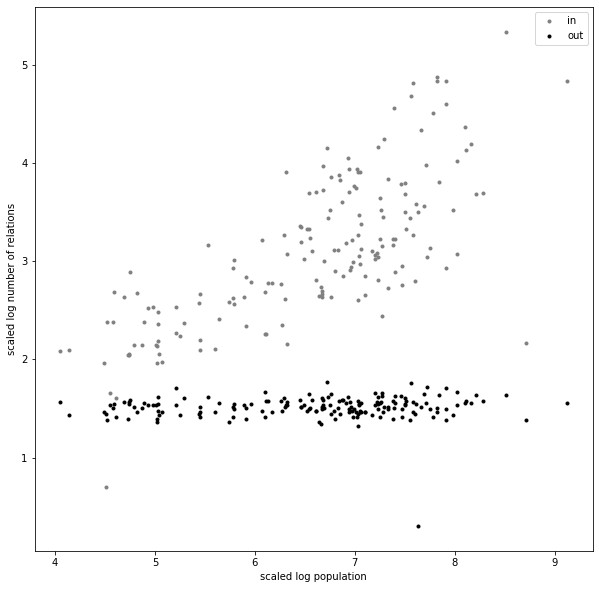

In [24]:
# CELL 24
import math

pops = list()
num_in_rels = list()
num_out_rels = list()
with open("ch7_cell23_countries_dev.tsv") as feats:
    next(feats) # skip header
    for line in feats:
        fields = line.strip().split("\t")
        pop = float(fields[-1])
        out_rels = float(fields[1])
        in_rels = float(fields[2])
        if out_rels == 0:
            continue
        pops.append(math.log(pop, 10))
        num_out_rels.append(math.log(out_rels, 10))
        num_in_rels.append(math.log(in_rels, 10))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(pops, num_in_rels, '.', color='gray', label='in')
plt.plot(pops, num_out_rels, '.', color='black', label='out')
plt.xlabel('scaled log population')
plt.ylabel('scaled log number of relations')
plt.savefig("ch7_cell24_logpop_vs_log_items.pdf", bbox_inches='tight', dpi=300)
plt.legend()
plt

From the figure we can see that the number of in relations is informative, but the number of out relations is not, most of the countries are involved in the same number of standard relations.

Let us now take 10 random countries and look at their time series data (Cell #25).

<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

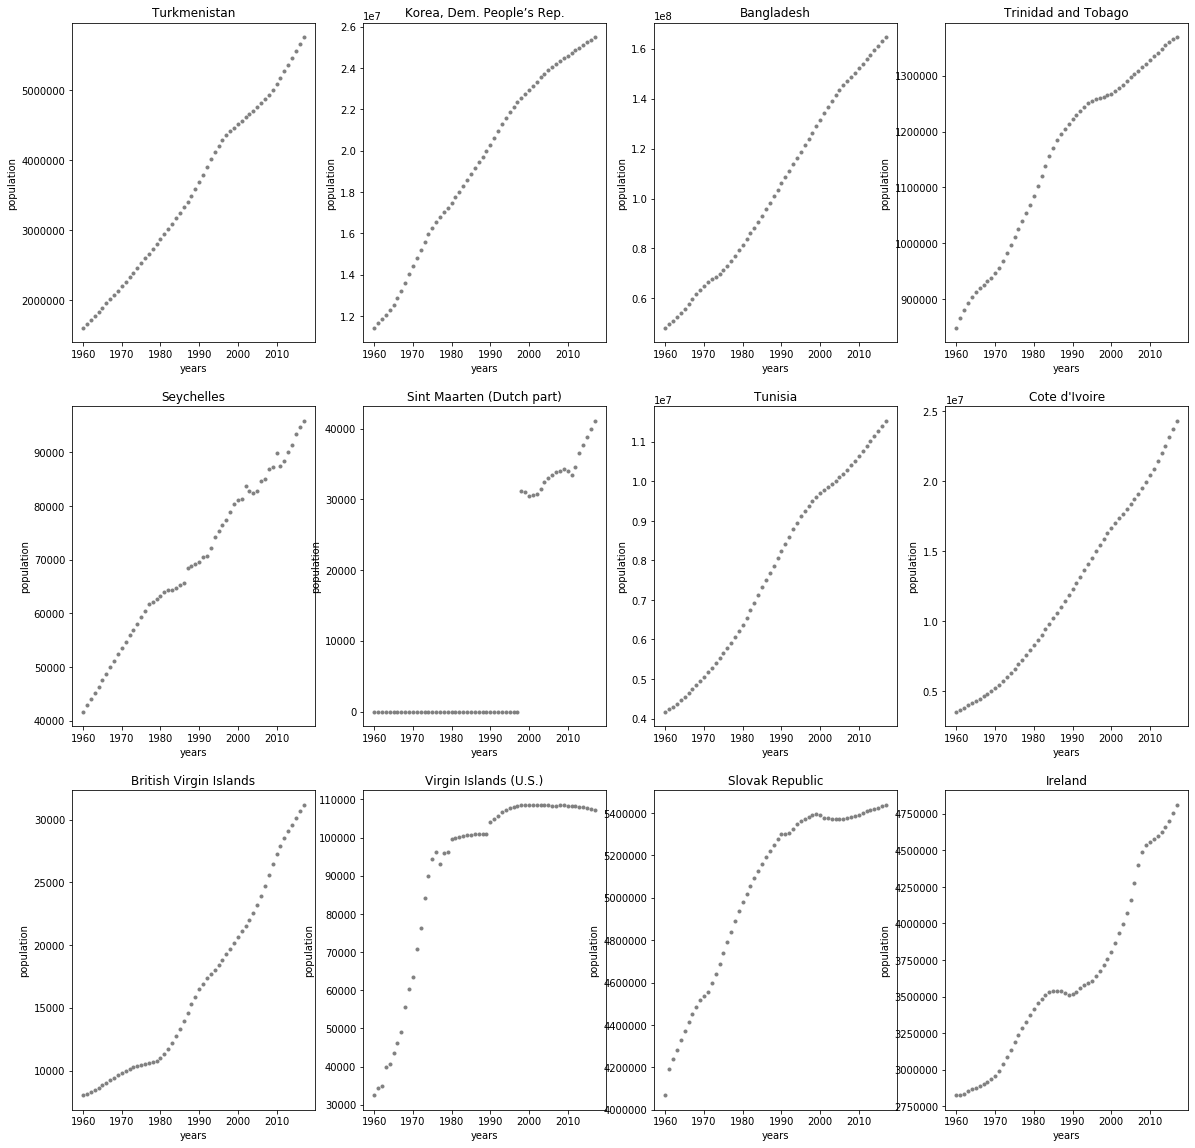

In [25]:
# CELL 25
import math
import random

years = list()
data = list()
with open("ch7_cell23_countries_dev.tsv") as feats:
    header = next(feats).strip().split("\t")
    years = list(map(int,header[3:]))
    for line in feats:
        fields = line.strip().split("\t")
        data.append( (fields[0], list(map(int,fields[3:]))) )
        
rand = random.Random(42)
rand.shuffle(data)
to_show = data[:12]

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

for idx, row in enumerate(to_show):
    plt.subplot(len(to_show) // 4, 4, idx + 1)
    
    plt.plot(years, row[1], '.', color='gray')
    plt.xlabel('years')
    plt.ylabel('population')
    plt.title(row[0])
    
plt.savefig("ch7_cell25_sample_country_pop.pdf", bbox_inches='tight', dpi=300)
plt

In the figure we can see trend reversal (Ireland in the 1980-1990, Slovak Republic in 2000-2010), missing data (Sint Maarten) and a variety of curves. Let us take a look at the ACF and PACF (Cell #26).

<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

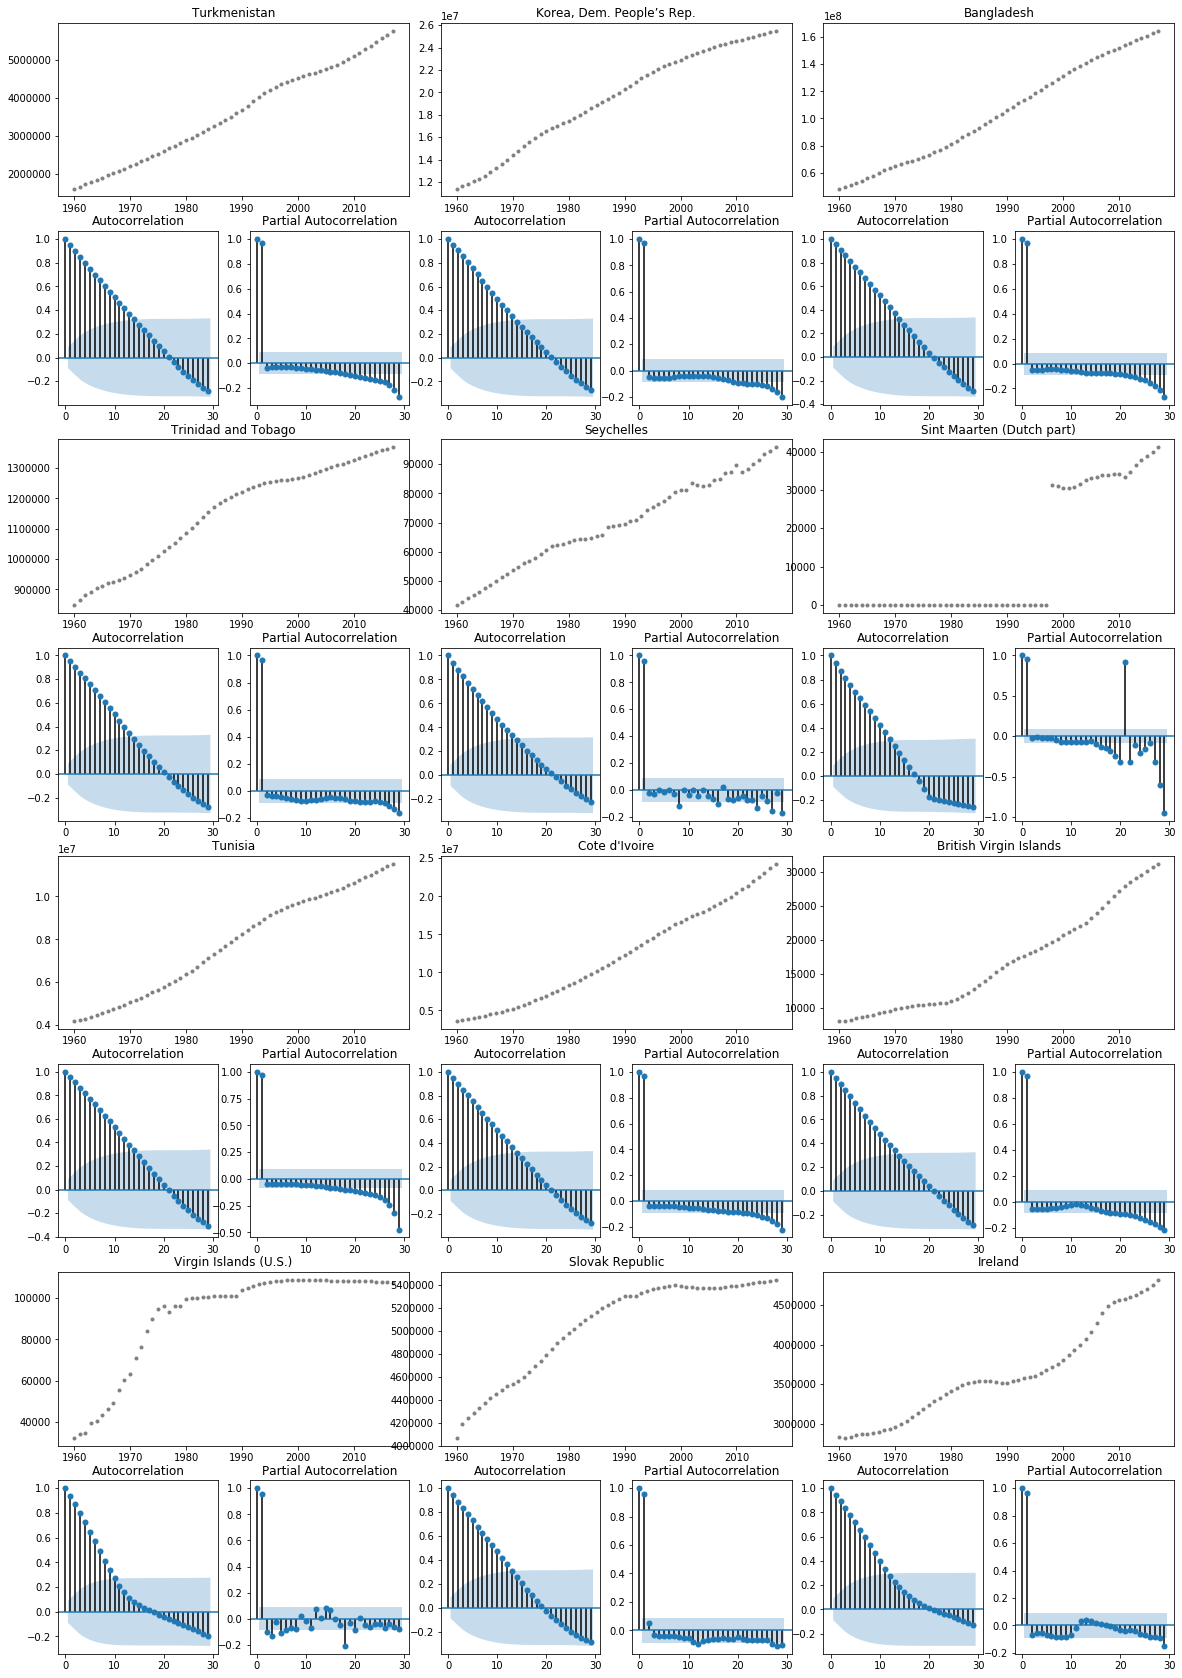

In [26]:
# CELL 26
import statsmodels.tsa.api as tsa
import math
import random

years = list()
data  = list()
with open("ch7_cell23_countries_dev.tsv") as feats:
    header = next(feats).strip().split("\t")
    years = list(map(int,header[3:]))
    for line in feats:
        fields = line.strip().split("\t")
        data.append( (fields[0], list(map(int,fields[3:]))) )
        
rand = random.Random(42)
rand.shuffle(data)
to_show = data[:12]

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 30]

lags=list(range(30))
layout = ( 2 * len(to_show) // 3, 3 * 2 )
for idx, row in enumerate(to_show):
    
    ts_plt   = plt.subplot2grid(layout, (2 * (idx // 3),     2 * (idx % 3)), colspan=2)
    acf_plt  = plt.subplot2grid(layout, (2 * (idx // 3) + 1, 2 * (idx % 3)) )
    pacf_plt = plt.subplot2grid(layout, (2 * (idx // 3) + 1, 2 * (idx % 3) + 1) )

    ts_plt.set_title(row[0])
    ts_plt.plot(years, row[1], '.', color='gray')
    tsa.graphics.plot_acf(row[1],  lags=lags, ax=acf_plt,  alpha=0.5)
    tsa.graphics.plot_pacf(row[1], lags=lags, ax=pacf_plt, alpha=0.5)
    
plt.savefig("ch7_cell26_sample_country_pop_acf.pdf", bbox_inches='tight', dpi=300)
plt

From all these graphs we see no impact on the PACF, so MA won't be needed. But we can see also a strong trend effect.

Let's try detrending with log (Cell #27).

<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

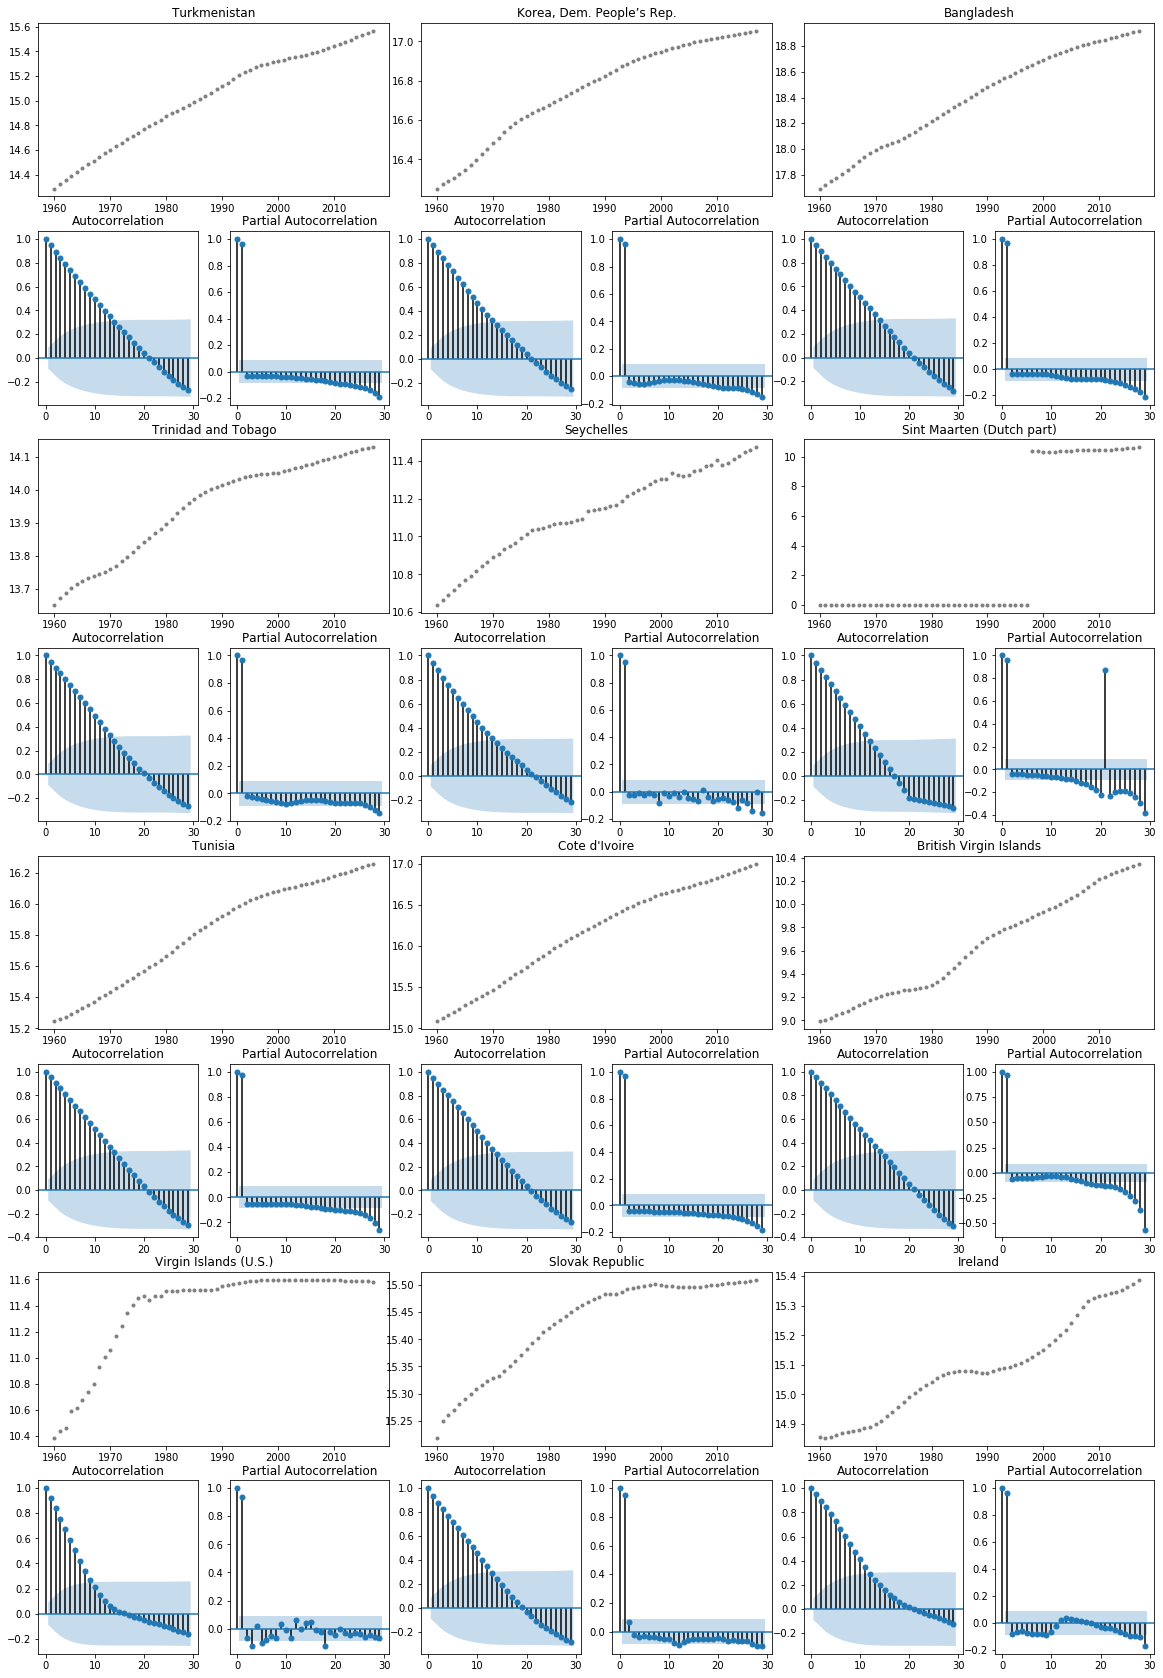

In [27]:
# CELL 27
import statsmodels.tsa.api as tsa
import math
import random

years = list()
data  = list()
with open("ch7_cell23_countries_dev.tsv") as feats:
    header = next(feats).strip().split("\t")
    years = list(map(int,header[3:]))
    for line in feats:
        fields = line.strip().split("\t")
        data.append( (fields[0], list(map(lambda x:0 if x=="0" else math.log(int(x)), fields[3:]))) )
        
rand = random.Random(42)
rand.shuffle(data)
to_show = data[:12]

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 30]

lags=list(range(30))
layout = ( 2 * len(to_show) // 3, 3 * 2 )
for idx, row in enumerate(to_show):
    
    ts_plt   = plt.subplot2grid(layout, (2 * (idx // 3),     2 * (idx % 3)), colspan=2)
    acf_plt  = plt.subplot2grid(layout, (2 * (idx // 3) + 1, 2 * (idx % 3)) )
    pacf_plt = plt.subplot2grid(layout, (2 * (idx // 3) + 1, 2 * (idx % 3) + 1) )

    ts_plt.set_title(row[0])
    ts_plt.plot(years, row[1], '.', color='gray')
    tsa.graphics.plot_acf(row[1],  lags=lags, ax=acf_plt,  alpha=0.5)
    tsa.graphics.plot_pacf(row[1], lags=lags, ax=pacf_plt, alpha=0.5)
    
plt.savefig("ch7_cell27_sample_country_logpop_acf.pdf", bbox_inches='tight', dpi=300)
plt

That did not work, let's try differencing then (Cell #28).

feateng/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

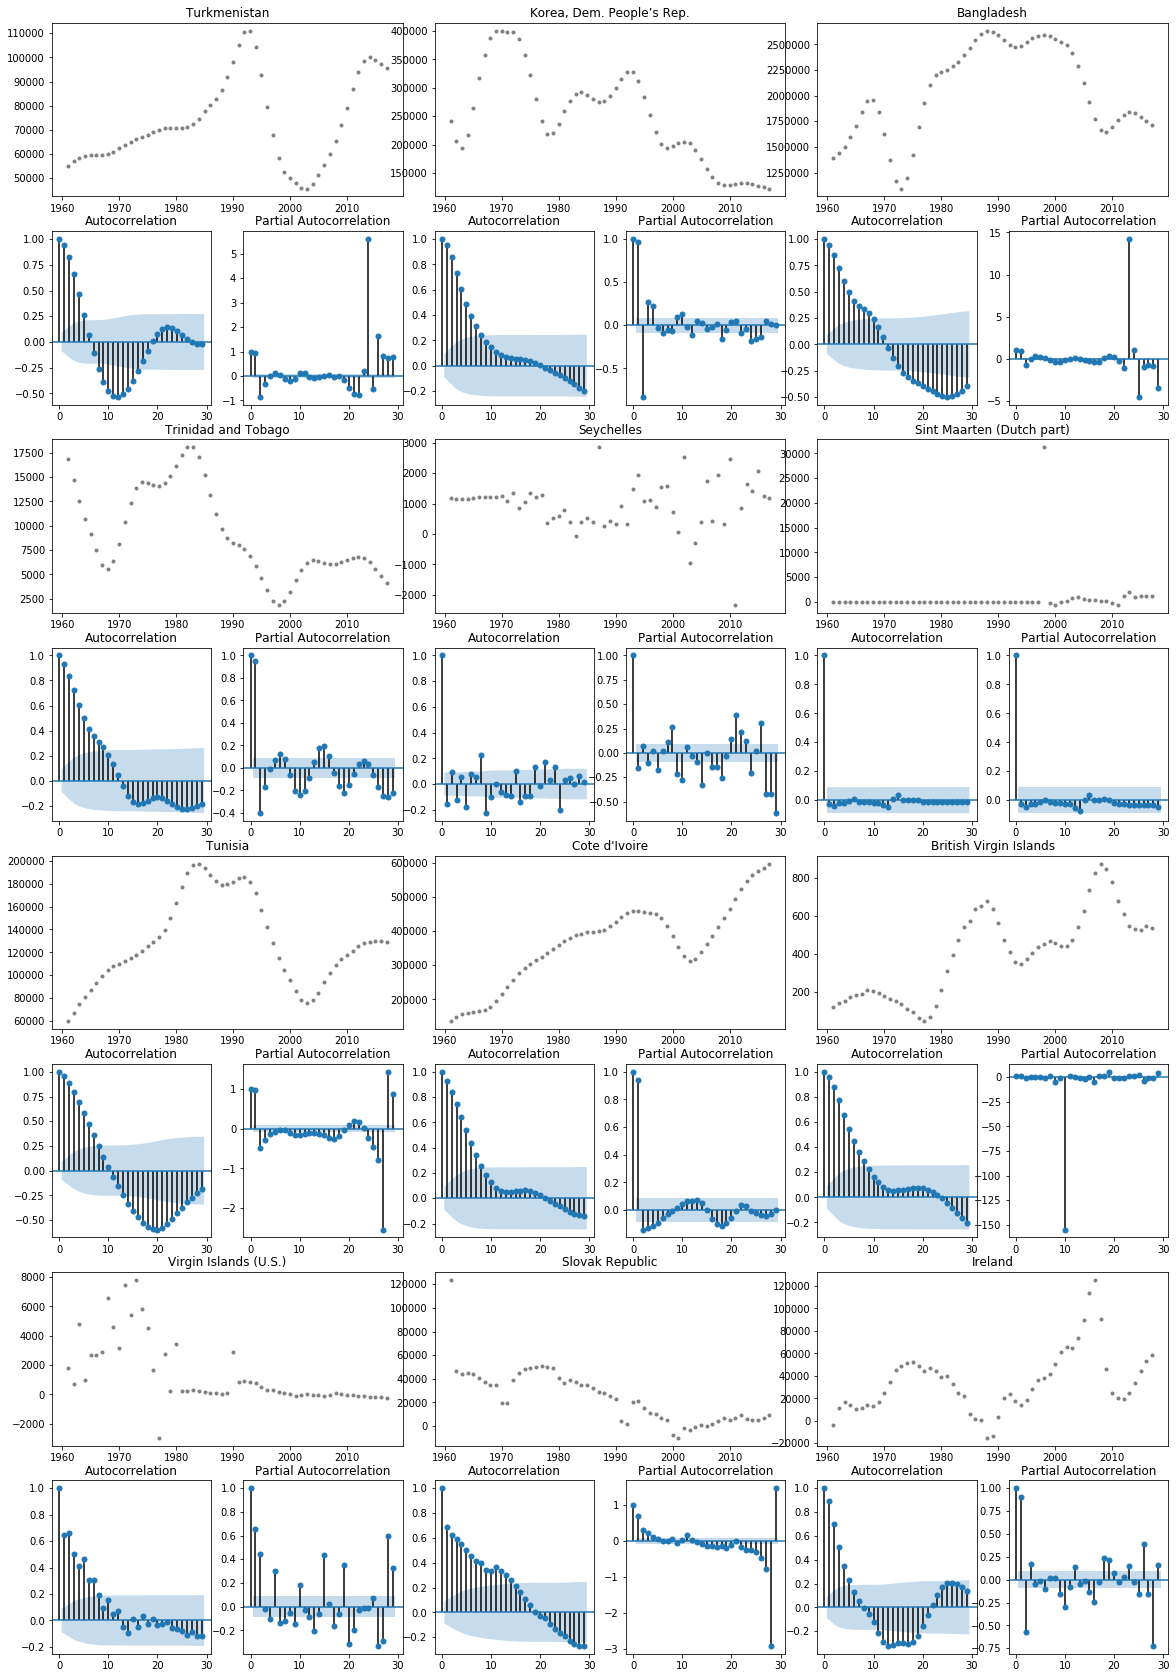

In [28]:
# CELL 28
import math
import random
import statsmodels.tsa.api as tsa
import numpy as np

years = list()
data  = list()
with open("ch7_cell23_countries_dev.tsv") as feats:
    header = next(feats).strip().split("\t")
    years = list(map(int,header[3:]))
    for line in feats:
        fields = line.strip().split("\t")
        data.append( (fields[0], list(map(int,fields[3:]))) )
        
rand = random.Random(42)
rand.shuffle(data)
table = np.array(list(map(lambda x:x[1], data)))
table = np.diff(table, n=1, axis=1) # the defaults, just for clarity
years.pop(0) # differencing losses one year

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 30]

lags   = list(range(30))
layout = ( 2 * 12 // 3, 3 * 2 )
for idx in range(12):
    row = ( data[idx][0], table[idx,:] )
    
    ts_plt   = plt.subplot2grid(layout, (2 * (idx // 3),     2 * (idx % 3)), colspan=2)
    acf_plt  = plt.subplot2grid(layout, (2 * (idx // 3) + 1, 2 * (idx % 3)) )
    pacf_plt = plt.subplot2grid(layout, (2 * (idx // 3) + 1, 2 * (idx % 3) + 1) )

    ts_plt.set_title(row[0])
    ts_plt.plot(years, row[1], '.', color='gray')
    tsa.graphics.plot_acf(row[1],  lags=lags, ax=acf_plt,  alpha=0.5)
    tsa.graphics.plot_pacf(row[1], lags=lags, ax=pacf_plt, alpha=0.5)
    
plt.savefig("ch7_cell28_sample_country_pop_acf_diff1.pdf", bbox_inches='tight', dpi=300)
plt

That seems more informative, let us look at second order differencing (Cell #29).

feateng/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

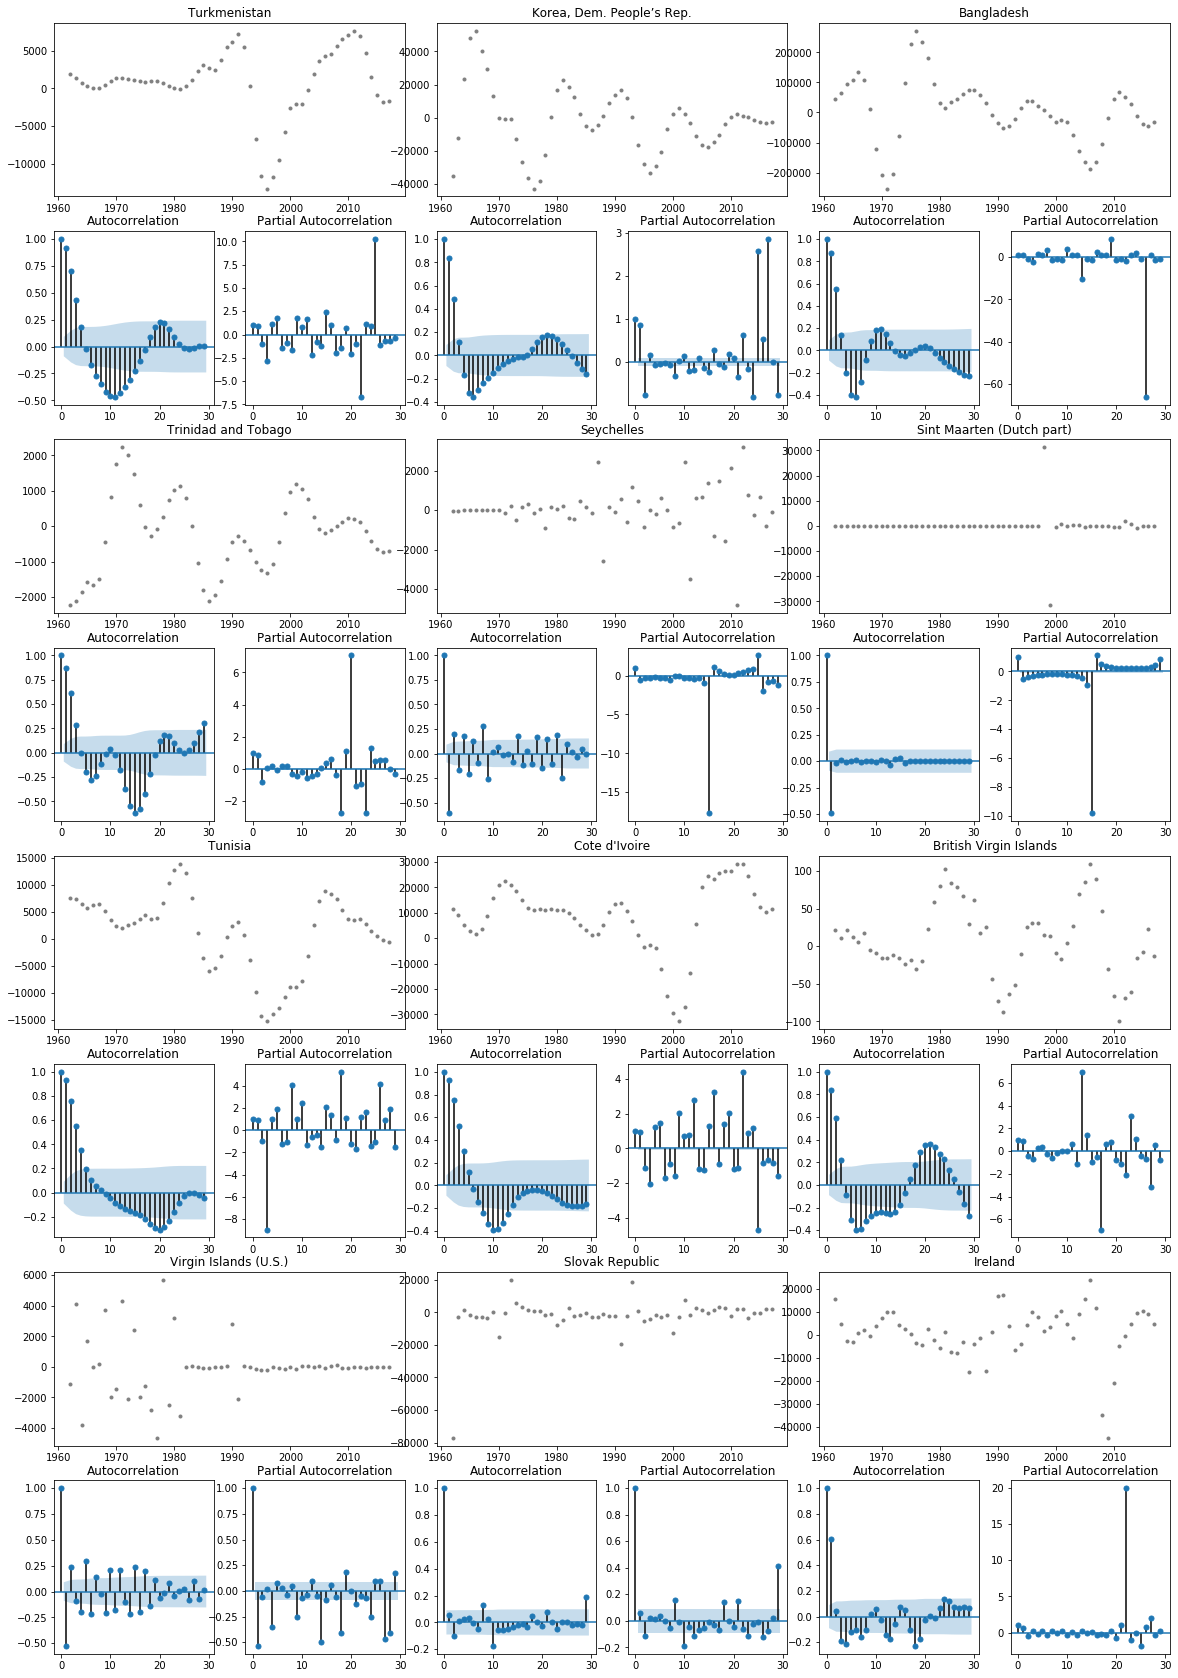

In [29]:
# CELL 29
import math
import random
import statsmodels.tsa.api as tsa
import numpy as np

years = list()
data  = list()
with open("ch7_cell23_countries_dev.tsv") as feats:
    header = next(feats).strip().split("\t")
    years = list(map(int,header[3:]))
    for line in feats:
        fields = line.strip().split("\t")
        data.append( (fields[0], list(map(int,fields[3:]))) )
        
rand = random.Random(42)
rand.shuffle(data)
table = np.array(list(map(lambda x:x[1], data)))
table = np.diff(table, n=2, axis=1) # the defaults, just for clarity
years = years[2:] # differencing losses two years

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 30]

lags   = list(range(30))
layout = ( 2 * 12 // 3, 3 * 2 )
for idx in range(12):
    row = ( data[idx][0], table[idx,:] )
    
    ts_plt   = plt.subplot2grid(layout, (2 * (idx // 3),     2 * (idx % 3)), colspan=2)
    acf_plt  = plt.subplot2grid(layout, (2 * (idx // 3) + 1, 2 * (idx % 3)) )
    pacf_plt = plt.subplot2grid(layout, (2 * (idx // 3) + 1, 2 * (idx % 3) + 1) )

    ts_plt.set_title(row[0])
    ts_plt.plot(years, row[1], '.', color='gray')
    tsa.graphics.plot_acf(row[1],  lags=lags, ax=acf_plt,  alpha=0.5)
    tsa.graphics.plot_pacf(row[1], lags=lags, ax=pacf_plt, alpha=0.5)
    
plt.savefig("ch7_cell29_sample_country_pop_acf_diff2.pdf", bbox_inches='tight', dpi=300)
plt

Hmm? Let's move to test with ADF (Cell #30).

In [30]:
# CELL 30
import math
import random
import statsmodels.tsa.api as tsa
import numpy as np
from statsmodels.tsa.stattools import adfuller

years = list()
data  = list()
with open("ch7_cell23_countries_dev.tsv") as feats:
    header = next(feats).strip().split("\t")
    years = list(map(int,header[3:]))
    for line in feats:
        fields = line.strip().split("\t")
        data.append( (fields[0], list(map(lambda x:1 if x=="0" else int(x), fields[3:]))) )
        
rand = random.Random(42)
rand.shuffle(data)
table = np.array(list(map(lambda x:x[1], data)))

table_log   = np.log(table) # the defaults, just for clarity
table_diff1 = np.diff(table, n=1, axis=1) # the defaults, just for clarity

lags=list(range(12))
for idx in range(12):
    x = table[idx]
    print("\n" + data[idx][0] + " " + str(idx))
    for regression in [ 'nc', 'c', 'ct', 'ctt']:
        adf, pvalue, crits, results = adfuller(x, regression=regression,autolag='AIC',store=True,regresults=True)
        if pvalue < 0.1:
            print("\n\t(reg={}) pvalue: {:1.5}".format(regression, pvalue))
            print("\t(reg={}) Lags used: {}".format(regression, results.usedlag))
        adf, pvalue, crits, results = adfuller(table_diff1[idx], 
                                               regression=regression,autolag='AIC',store=True,regresults=True)
        if pvalue < 0.1:
            print("\n\t(reg={}) pvalue (diff 1): {:1.5}".format(regression, pvalue))
            print("\t(reg={}) Lags used: {}".format(regression, results.usedlag))

        adf, pvalue, crits, results = adfuller(table_log[idx], 
                                               regression=regression,autolag='AIC',store=True,regresults=True)
        if pvalue < 0.1:
            print("\n\t(reg={}) pvalue (log): {:1.5}".format(regression, pvalue))
            print("\t(reg={}) Lags used: {}".format(regression, results.usedlag))
    



Turkmenistan 0

	(reg=c) pvalue (log): 0.033629
	(reg=c) Lags used: 11

Korea, Dem. People’s Rep. 1

	(reg=nc) pvalue (diff 1): 0.03045
	(reg=nc) Lags used: 8

	(reg=ctt) pvalue (diff 1): 0.00010948
	(reg=ctt) Lags used: 10

	(reg=ctt) pvalue (log): 0.00011662
	(reg=ctt) Lags used: 8

Bangladesh 2

	(reg=nc) pvalue (log): 0.071694
	(reg=nc) Lags used: 8

	(reg=c) pvalue (log): 2.4863e-07
	(reg=c) Lags used: 11

	(reg=ct) pvalue: 0.00052031
	(reg=ct) Lags used: 8

Trinidad and Tobago 3

	(reg=nc) pvalue (diff 1): 0.0033378
	(reg=nc) Lags used: 11

	(reg=c) pvalue: 2.2847e-07
	(reg=c) Lags used: 11

	(reg=c) pvalue (log): 1.7288e-12
	(reg=c) Lags used: 11

	(reg=ct) pvalue (diff 1): 2.1334e-07
	(reg=ct) Lags used: 10

	(reg=ct) pvalue (log): 0.00036514
	(reg=ct) Lags used: 11

	(reg=ctt) pvalue: 1.5116e-06
	(reg=ctt) Lags used: 6

	(reg=ctt) pvalue (diff 1): 1.1549e-07
	(reg=ctt) Lags used: 10

Seychelles 4

	(reg=c) pvalue (diff 1): 7.8076e-14
	(reg=c) Lags used: 0

	(reg=c) pvalue (lo

We can see that many countries do not achieve stationarity with differencing or log nor liner or quadratic regression. For others, it depends to find the exact method. The simplest one is Turkmekistan that is stationary on its log, so let's try to predict it (Cell #31).

Log forecast: (array([15.54893032]), array([0.02365336]), array([[15.5025706 , 15.59529005]]))
Log actual: 15.566113775425455
Absolute error, predicted: -98,098.35004603863
Absolute error, previous: -95,530.99999999441


<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

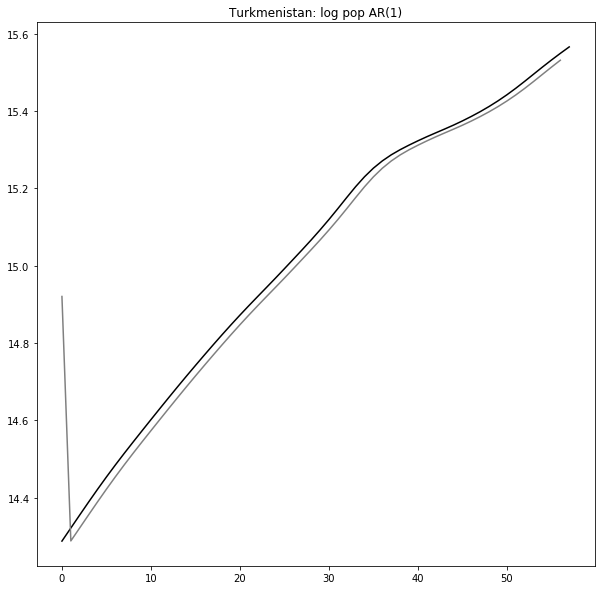

In [31]:
# CELL 31
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA( table_log[0,:-1], order=(1,0,0)  )
ar_results = model.fit()

print("Log forecast: {}".format(ar_results.forecast(1)))
print("Log actual: {}".format(table_log[0,-1]))
print("Absolute error, predicted: {:,}".format(math.exp(ar_results.forecast(1)[0][0]) - math.exp(table_log[0,-1])))
print("Absolute error, previous: {:,}".format(math.exp(table_log[0,-2]) - math.exp(table_log[0,-1])))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(table_log[0], color='black')
plt.plot(ar_results.fittedvalues, color='gray')
plt.title("{}: log pop AR(1)".format(data[0][0]))

plt.savefig("ch7_cell31_turmekistan_log_ar1.pdf", bbox_inches='tight', dpi=300)
plt

That looks nice, but there is a clear lag between the prediction and the actual value. Also, the prediction error is 3,000 people worse off than using the last known value of the sequence. It is a shame to do so much work to end up worse than were we started. But in Cell #30 the autolag found stationarity at lag 11, so let's try with an AR(11) process instead (Cell #32).

feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
feateng/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1500: RuntimeWarning: invalid value encountered in sqrt
  fcasterr = np.sqrt(sigma2 * np.cumsum(ma_rep**2))


Log forecast: (array([15.56610628]), array([nan]), array([[nan, nan]]))
Log actual: 15.566113775425455
Absolute error, predicted: -43.17216261755675
Absolute error, previous: -95,530.99999999441
Absolute error, previous + diff: 1,729.0000000065193


<module 'matplotlib.pyplot' from 'feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

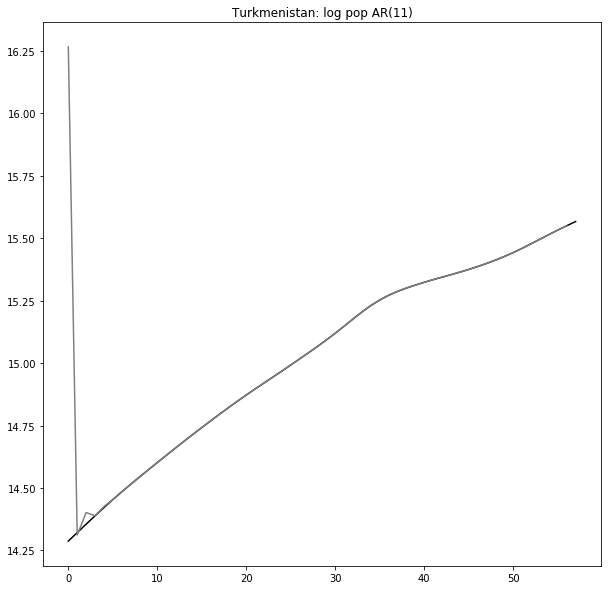

In [32]:
# CELL 32
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA( table_log[0,:-1], order=(11, 0, 0)  )
ar_results = model.fit()

print("Log forecast: {}".format(ar_results.forecast(1)))
print("Log actual: {}".format(table_log[0,-1]))

log_forecast = ar_results.forecast(1)[0][0]
forecast = math.exp(log_forecast)
log_actual = table_log[0, -1]
actual = math.exp(log_actual)
previous = math.exp(table_log[0, -2])
previous2 = math.exp(table_log[0, -3])

print("Absolute error, predicted: {:,}".format(forecast - actual))
print("Absolute error, previous: {:,}".format(previous - actual))
print("Absolute error, previous + diff: {:,}".format(previous + (previous - previous2) - actual))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(table_log[0], color='black')
plt.plot(ar_results.fittedvalues, color='gray')
plt.title("{}: log pop AR(11)".format(data[0][0]))

plt.savefig("ch7_cell32_turmekistan_log_ar11.pdf", bbox_inches='tight', dpi=300)
plt

Now we are in business! The question is how to operationalize obtaining all these fitted models and predictions automatically. I discuss this with the third featurization, let us start with the baselines, no time series and using the time series as a training data. 

Given the EDA, it looks likely the TS systems will underbehave compared to the baseline approaches.

## First Featurization: no TS data

Let us start by using only the number of relations (Cell #33)

Training on 140 countries
C 0.01 RMSE 1.074204810382449
C 0.1 RMSE 0.8090564628670425
C 0.5 RMSE 0.7091245240776414
C 1.0 RMSE 0.7177892887020444
C 1.5 RMSE 0.7159910497027019
C 2.0 RMSE 0.7054068673855378
C 5.0 RMSE 0.7028442756177381
C 10.0 RMSE 0.6974059125373745
C 50.0 RMSE 0.7169340339921174
C 100.0 RMSE 0.7725200419969169
Best C 10.0 best RMSE 0.6974059125373745
Epsilon 0.0001 RMSE 0.6913114694367364
Epsilon 0.001 RMSE 0.6871954628240701
Epsilon 0.01 RMSE 0.6951797961785876
Epsilon 0.02 RMSE 0.695918991384224
Epsilon 0.05 RMSE 0.6974059125373745
Epsilon 0.1 RMSE 0.6834592511300636
Epsilon 0.2 RMSE 0.7231458831001565
Epsilon 0.5 RMSE 1.1225989857188645
Epsilon 0.0 RMSE 0.6914775913481219
Epsilon 1.0 RMSE 1.1225989857188645
Epsilon 10.0 RMSE 1.1225989857188647
Epsilon 100.0 RMSE 1.1225989857188663
Best epsilon 0.1 best RMSE 0.6834592511300636
RMSE 0.6512360835560099


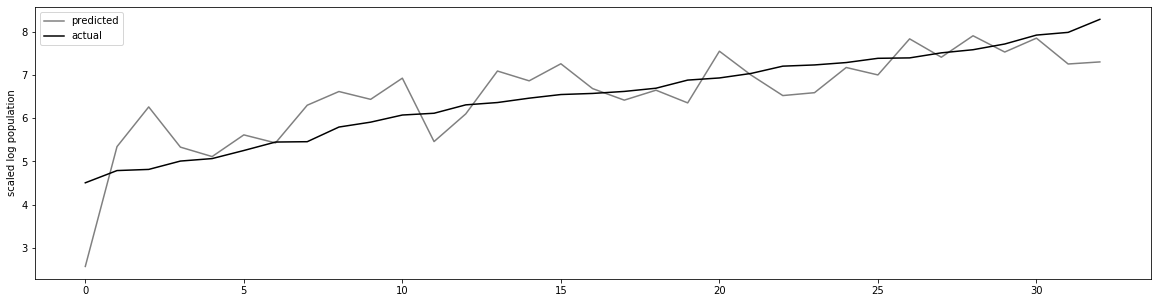

In [33]:
# CELL 33
import math
import random
from sklearn.svm import SVR
import numpy as np

rand = random.Random(42)
train_data = list()
test_data  = list()
header = None
with open("ch7_cell23_countries_dev.tsv") as feats:
    header = next(feats)
    header = header.strip().split("\t")
    header = [ header[0], "log_" + header[1], "log_" + header[2], "logpop" ]
    for line in feats:
        fields   = line.strip().split("\t")
        name     = fields[0]
        pop      = float(fields[-1])
        out_rels = float(fields[1])
        in_rels  = float(fields[2])
        if out_rels == 0:
            out_rels = 1
        row = ( [ math.log(out_rels, 10), math.log(in_rels, 10) ], math.log(pop, 10), name )
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
            
with open("ch7_cell33_feat1.tsv", "w") as feat:
    feat.write("\t".join(header) + "\n")
    for feats, logpop, name in train_data + test_data:
        feat.write("{}\t{}\t{}\n".format(name, "\t".join(map(str,feats)), logpop))
               
test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))

# SVRs need scaling
xtrain_min = xtrain.min(axis=0); xtrain_max = xtrain.max(axis=0)
# some can be zero if the column is constant in training
xtrain_diff = xtrain_max - xtrain_min
for idx in range(len(xtrain_diff)):
    if xtrain_diff[idx] == 0.0:
        xtrain_diff[idx] = 1.0
xtrain_scaling = 1.0 / xtrain_diff
xtrain -= xtrain_min; xtrain *= xtrain_scaling

ytrain_orig = ytrain.copy()
ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

xtest -= xtrain_min; xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

# train
print("Training on {:,} countries".format(len(xtrain)))

best_c = 100.0
best_epsilon = 0.05

SEARCH_TEST = 50
best_rmse = 1000
for c in [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 50.0, 100.0]:
    svr_rbf = SVR(epsilon=0.05, C=c, gamma='auto')
    svr_rbf.fit(xtrain[:-SEARCH_TEST,:], ytrain[:-SEARCH_TEST])
    ytrain_pred_end = svr_rbf.predict(xtrain[-SEARCH_TEST:,:])
    ytrain_pred_end *= 1.0/ytrain_scaling
    ytrain_pred_end += ytrain_min
    RMSE = math.sqrt(sum((ytrain_orig[-SEARCH_TEST:] - ytrain_pred_end)**2) / SEARCH_TEST)
    print("C", c, "RMSE", RMSE)
    if RMSE < best_rmse:
        best_c = c
        best_rmse = RMSE

print("Best C", best_c,"best RMSE", best_rmse)        

best_rmse = 1000
for epsilon in [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.0, 1.0, 10.0, 100.0]:
    svr_rbf = SVR(epsilon=epsilon, C=best_c, gamma='auto')
    svr_rbf.fit(xtrain[:-SEARCH_TEST,:], ytrain[:-SEARCH_TEST])
    ytrain_pred_end = svr_rbf.predict(xtrain[-SEARCH_TEST:,:])
    ytrain_pred_end *= 1.0/ytrain_scaling
    ytrain_pred_end += ytrain_min
    RMSE = math.sqrt(sum((ytrain_orig[-SEARCH_TEST:] - ytrain_pred_end)**2) / SEARCH_TEST)
    print("Epsilon", epsilon, "RMSE", RMSE)
    if RMSE < best_rmse:
        best_epsilon = epsilon
        best_rmse = RMSE

print("Best epsilon", best_epsilon,"best RMSE", best_rmse)

svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual",    color='black')
plt.ylabel('scaled log population')
plt.savefig("ch7_cell33_svr_feat1.pdf", bbox_inches='tight', dpi=300)
plt.legend()

The RMSE is very small for the amount of training data and pauperity of the features. Let us add the TS as extra features.

## Second Featurization: Using TS as Features

I will also try to find the range that produces the best results (Cell #34).

Training on 140 countries
History 1
Best C 1.5 best RMSE 0.12233640335264187
Best epsilon 0.0001 best RMSE 0.03251167662471659
History 2
Best C 1.5 best RMSE 0.11938965515214714
Best epsilon 0.0 best RMSE 0.02921682970902913
History 3
Best C 1.0 best RMSE 0.1182001900295011
Best epsilon 0.0001 best RMSE 0.03130831272980187
History 4
Best C 0.5 best RMSE 0.11731038389815374
Best epsilon 0.001 best RMSE 0.04048445439648792
History 5
Best C 1.0 best RMSE 0.11746844884537583
Best epsilon 0.0 best RMSE 0.031175872317681545
History 6
Best C 1.0 best RMSE 0.11775230311849348
Best epsilon 0.0 best RMSE 0.03174244213583967
History 7
Best C 0.5 best RMSE 0.1181798897689338
Best epsilon 0.0 best RMSE 0.043828397192121886
History 8
Best C 0.5 best RMSE 0.11876236428723513
Best epsilon 0.0001 best RMSE 0.043602656633612985
History 9
Best C 0.5 best RMSE 0.11985469751900125
Best epsilon 0.0001 best RMSE 0.04405567070698307
History 10
Best C 0.5 best RMSE 0.12127441973124253
Best epsilon 0.0001 best 

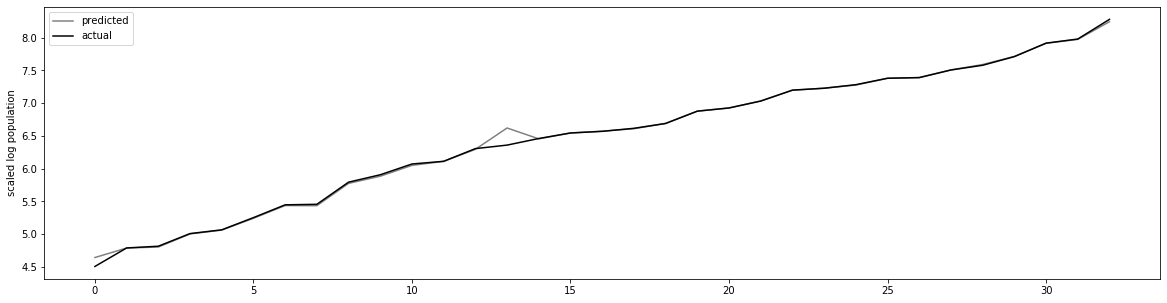

In [34]:
# CELL 34
import math
import random
from sklearn.svm import SVR
import numpy as np

rand = random.Random(42)
train_data = list()
test_data  = list()
header = None
with open("ch7_cell23_countries_dev.tsv") as feats:
    header = next(feats)
    logheader = list(map(lambda x:"log_"+x, header.strip().split("\t")))
    header = [ header[0] ] + logheader[1:-1] + [ "logpop" ]
    for line in feats:
        fields = line.strip().split("\t")
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:-1]))
        for idx, feat in enumerate(feats):
            if feat == 0:
                feats[idx] = 1
        row = ( list(map(lambda x:math.log(x, 10), feats)), math.log(pop, 10), name )
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
            
test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

full_xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
full_xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# SVRs need scaling
full_xtrain_min = full_xtrain.min(axis=0); full_xtrain_max = full_xtrain.max(axis=0)
# some can be zero if the column is constant in training
full_xtrain_diff = full_xtrain_max - full_xtrain_min
for idx in range(len(full_xtrain_diff)):
    if full_xtrain_diff[idx] == 0.0:
        full_xtrain_diff[idx] = 1.0
full_xtrain_scaling = 1.0 / full_xtrain_diff
full_xtrain -= full_xtrain_min; full_xtrain *= full_xtrain_scaling

ytrain_orig = ytrain.copy()
ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

full_xtest_orig = full_xtest.copy()
full_xtest -= full_xtrain_min; full_xtest *= full_xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

# train
print("Training on {:,} countries".format(len(full_xtrain)))
               
best_history = len(header) - 5
best_history_rmse = 1000
best_history_c = 100.0
best_history_epsilon = 0.05

for history in range(1, len(header) - 5):
    
    print("History", history)
    
    xtrain = np.zeros( (full_xtrain.shape[0], 2 + history))
    xtrain[:,:2] = full_xtrain[:,:2] # rels
    xtrain[:, 2:] = full_xtrain[:,-history:]
    
    best_c = 100.0
    best_epsilon = 0.05

    SEARCH_TEST = 50
    best_rmse = 1000
    for c in [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 50.0, 100.0]:
        svr_rbf = SVR(epsilon=0.05, C=c, gamma='auto')
        svr_rbf.fit(xtrain[:-SEARCH_TEST,:], ytrain[:-SEARCH_TEST])
        ytrain_pred_end = svr_rbf.predict(xtrain[-SEARCH_TEST:,:])
        ytrain_pred_end *= 1.0/ytrain_scaling
        ytrain_pred_end += ytrain_min
        RMSE = math.sqrt(sum((ytrain_orig[-SEARCH_TEST:] - ytrain_pred_end)**2) / SEARCH_TEST)
        if RMSE < best_rmse:
            best_c = c
            best_rmse = RMSE

    print("Best C", best_c,"best RMSE", best_rmse)        

    best_rmse = 1000
    for epsilon in [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.0, 1.0, 10.0, 100.0]:
        svr_rbf = SVR(epsilon=epsilon, C=best_c, gamma='auto')
        svr_rbf.fit(xtrain[:-SEARCH_TEST,:], ytrain[:-SEARCH_TEST])
        ytrain_pred_end = svr_rbf.predict(xtrain[-SEARCH_TEST:,:])
        ytrain_pred_end *= 1.0/ytrain_scaling
        ytrain_pred_end += ytrain_min
        RMSE = math.sqrt(sum((ytrain_orig[-SEARCH_TEST:] - ytrain_pred_end)**2) / SEARCH_TEST)
        if RMSE < best_rmse:
            best_epsilon = epsilon
            best_rmse = RMSE

    print("Best epsilon", best_epsilon,"best RMSE", best_rmse)

    if best_rmse < best_history_rmse:
        best_history_rmse = best_rmse
        best_history = history
        best_history_c = best_c
        best_history_epsilon = best_epsilon

print("Best history", best_history, "best c", best_c, "best epsilon", best_epsilon,"best RMSE", best_rmse)

xtrain = np.zeros( (full_xtrain.shape[0], 2 + best_history))
xtrain[:,:2] = full_xtrain[:,:2] # rels
xtrain[:, 2:] = full_xtrain[:,-best_history:]

xtest = np.zeros( (full_xtest.shape[0], 2 + best_history))
xtest[:,:2] = full_xtest[:,:2] # rels
xtest[:, 2:] = full_xtest[:,-best_history:]

svr_rbf = SVR(epsilon=best_history_epsilon, C=best_history_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

# use previous year to predict current

RMSE = math.sqrt(sum((full_xtest_orig[:,-1] - ytest_pred)**2) / len(ytest))
print("Previous year RMSE", RMSE)
               
with open("ch7_cell34_feat2.tsv", "w") as feat:
    feat.write("\t".join(header[:2] + header[-(best_history+1):]) + "\n")
    for feats, logpop, name in train_data + test_data:
        feat.write("{}\t{}\t{}\n".format(name, "\t".join(map(str,feats[:2] + feats[-best_history:])), logpop))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch7_cell34_svr_feat2.pdf", bbox_inches='tight', dpi=300)
plt.legend()

That is going to be very difficult to improve upon but we can see that the error rate for just using the previous year is comparable with the SVR. Let us give the TS a try.

## Third Featurization: Prediction as Feature

To get TS predictions, I will do the following:

* Keep current year (row[-1]) unseen as it is the test data
* Train on all up to two-previous-to-last (including row[-3]), test on previous-to-last (row[-2])
* If the error is less than the error from the predictor row[-3] + (row[-3] - row[-4]), use the TS prediction, otherwise
* I will also save the method that was used to obtain the prediction.
* If everything fails, try using smaller data segments.

In terms of detrending techniques I will try:

* no detrending
* log
* linear regression

I will skip differencing and quadratic regression as it did not seem particularly useful in EDA and it makes the code more complicated. I use the simplest possible detrending, basically preferring the simplest possible model.

I will then train a model using the history from previous featurization (2 lags) and the prediction from the TS (if any, otherwise use the previous + previous_diff). Cell #35.

In [35]:
# CELL 35
import math
import random
import statsmodels.tsa.api as tsa
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

years = list()
data  = list()
with open("ch7_cell23_countries_dev.tsv") as feats:
    header = next(feats).strip().split("\t")
    years = list(map(int,header[3:]))
    for line in feats:
        fields = line.strip().split("\t")
        data.append( (fields[0], list(map(lambda x:1 if x=="0" else int(x), fields[3:])),
                      list(map(lambda x:1 if x=="0" else math.log(float(x), 10), fields[1:3]))) )

        
table     = np.array(list(map(lambda x:x[1], data)))
table_log = np.log10(table)

conditions = [
    ( 'base', 'c',  50 ),
    ( 'base', 'c',  25 ),
    ( 'log',  'c',  50 ),
    ( 'log',  'c',  25 ),
    ( 'base', 'ct', 50 ),
    ( 'base', 'ct', 25 ),
    ( 'log',  'ct', 50 ),
    ( 'log',  'ct', 25 ),
]

predicted        = list()
condition_used   = list()
errors           = 0
fitted_countries = set()

for country_idx in range(table.shape[0]):
    print(country_idx, data[country_idx][0])
    years  = table[country_idx, : -2] # skip last year
    target = table[country_idx, -2]  # use previous to last for prediction
    prediction = years[-1] + (years[-1] - years[-2])
    best_prediction_se = (target - prediction)**2
    best_condition     = ( 'none', 'c', 2 )
    
    for condition in conditions:
        length = condition[-1]
        if condition[0] == 'base':
            this_table = table
        else:
            this_table = table_log
        years = this_table[country_idx, -(length+2): -2] # skip last year
        target = table[country_idx, -2]  # use previous to last for prediction
        regression = condition[1]
        adf, pvalue, crits, results = adfuller(years, regression=regression,autolag='AIC',
                                               store=True,regresults=True)
        if pvalue < 0.1:
            print("\t{}".format(condition))
            # train and predict          
            model = ARIMA( results.resols.resid, order=(results.usedlag, 0, 0) )
            
            try:
                ar_results = model.fit()
            except:
                print("\t\te")
                errors += 1
                continue
                
            fitted_countries.add(country_idx)
                
            df_ols = int(results.resols.df_model)
            
            predict     = ar_results.forecast(1)[0][0]
            ols_predict = results.resols.predict(np.diff(years[-(df_ols+2):]).reshape(1,df_ols+1))[0]

            predict += years[-1] + ols_predict
            if condition[0] == 'log':
                predict = 10**predict
            se = (target - predict)**2
            if se <= best_prediction_se:
                print("\t\ts {:,} and {:,}".format(int(se), best_prediction_se))
                best_prediction_se = se
                best_condition = condition
                break
            else:
                print("\t\t{:,} vs {:,}".format(int(se), best_prediction_se))
                
    diff_prediction = table[country_idx, -2] + (table[country_idx, -2] - table[country_idx, -3])

    if best_condition[0] != 'none':
        # compute final prediction
        length = best_condition[-1]
        if best_condition[0] == 'base':
            this_table = table
        else:
            this_table = table_log
        years = this_table[country_idx, -(length+1): -1] # skip last year
        regression = best_condition[1]
        adf, pvalue, crits, results = adfuller( years, regression=regression,autolag='AIC',
                                               store=True,regresults=True)
        if pvalue < 0.1:
            # train and predict
            model = ARIMA( results.resols.resid, order=(results.usedlag, 0, 0)  )
            in_error = False
            try:
                ar_results = model.fit()
            except:
                print("\t\t\tE")
                in_error = True
                errors += 1
            if in_error:
                best_condition = ( 'none', 'c', 2 )
                prediction = diff_prediction
            else:
                df_ols = int(results.resols.df_model)

                prediction = ar_results.forecast(1)[0][0]
                ols_predict = results.resols.predict(np.diff(years[-(df_ols+2):]).reshape(1,df_ols+1))[0]
                prediction += years[-1] + ols_predict
                  
                if best_condition[0] == 'log':
                    prediction = 10**prediction
        else:
            best_condition = ( 'none', 'c', 2 )
            prediction = diff_prediction
    else:
            prediction = diff_prediction
    predicted.append(prediction)
    condition_used.append(best_condition)

print("Errors",    errors)
print("Fitted",    len(fitted_countries))
print("Using TS:", len(list(filter(lambda x:x[0] != 'none',condition_used))))

with open("ch7_cell35_ts_predicted.tsv", "w") as pred:
    pred.write("name\tpredicted\tmethod\tregression\tsize\n")
    for country_idx, pair in enumerate(zip(predicted, condition_used)):
        prediction, condition = pair
        pred.write("{}\t{}\t{}\t{}\t{}\n".format(data[country_idx][0], prediction, *condition))

0 Greenland
1 Senegal
	('log', 'c', 50)
		10,983,523,149 vs 13,965,169
	('log', 'ct', 25)
		e
2 Cote d'Ivoire
	('log', 'ct', 25)
		e
3 Mozambique
	('log', 'c', 25)
		e
4 Somalia
5 Grenada


feateng/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


	('log', 'ct', 50)
		6,905 vs 961
6 Cuba
	('base', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		630,590,950,713,677,312 vs 50,623,225
	('base', 'c', 25)
		e
	('log', 'c', 50)
		136,315,134 vs 50,623,225
	('log', 'c', 25)
		e
7 Bhutan
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
	('base', 'ct', 50)
		7,808,174,442,944,441 vs 312,481
8 Turks and Caicos Islands
	('log', 'c', 50)
		81,441 vs 1,521
	('log', 'c', 25)
		3,784 vs 1,521
9 Bosnia and Herzegovina
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
10 Cambodia
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
	('log', 'ct', 50)
		2,276,217,702 vs 4,452,100
11 Micronesia, Fed. Sts.
	('base', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
feateng/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1500: RuntimeWarning: invalid value encountered in sqrt
  fcasterr = np.sqrt(sigma2 * np.cumsum(ma_rep**2))


		34,269,070,884 vs 7,396
	('base', 'c', 25)
		e
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		391,783 vs 7,396
	('base', 'ct', 50)
		56,061,545,091 vs 7,396
	('base', 'ct', 25)
		e
	('log', 'ct', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		444,380 vs 7,396
	('log', 'ct', 25)
		e
12 Cyprus
13 Montenegro
	('base', 'c', 50)
		11,193,475,958,160 vs 42,025
	('base', 'c', 25)
		e
	('log', 'c', 50)
		230,872 vs 42,025
	('log', 'c', 25)
		e
	('base', 'ct', 50)
		275,763,655,327,512 vs 42,025
	('log', 'ct', 50)
		407,790 vs 42,025
14 Haiti
	('log', 'c', 50)
		737,398,710 vs 5,391,684
	('log', 'c', 25)
		e
15 Burundi
	('log', 'ct', 25)
		e
16 France
	('log', 'ct', 50)
		58,921,506,977 vs 118,200,384
	('log', 'ct', 25)
		216,831,572,901 vs 118,200,384
17 Guyana
	('base', 'c', 50)
		2,767,692,917,741,786 vs 110,224
	('base', 'c', 25)
		e
	('log', 'c', 50)
		31,745,251 vs 110,224
	('log', 'c', 25)
		e
18 United Arab Emirates
19 Sierra Leone
	('log', 'ct', 25)
		e
20 Papua New Guinea
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
21 United States
	('base', 'c', 25)
		e
	('base', 'ct', 50)
		269,526,146,963,266,954,103,619,584 vs 2,623,283,524
22 Mexico
	('log', 'c', 25)
		e
	('log', 'ct', 25)
		e
23 Poland
	('base', 'c', 25)
		e
	('

feateng/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)


		e
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
25 Libya
	('base', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		96,261,097,622,950,336 vs 753,557,401
	('base', 'c', 25)
		e
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		1,027,829,616 vs 753,557,401
	('log', 'c', 25)
		e
	('log', 'ct', 50)
		1,126,299,933 vs 753,557,401
26 Vietnam
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		19,712,076,414 vs 849,547,609
27 Botswana
	('log', 'ct', 25)
		e
28 Angola
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
29 Syrian Arab Republic
	('base', 'ct', 25)
		e
30 Turkmenistan
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		2,029,920,382 vs 3,179,089
31 Cabo Verde
	('base', 'c', 25)
		e
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		5,847,012 vs 29,241
	('base', 'ct', 50)
		368,264,669,101,568 vs 29,241
	('log', 'ct', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		12,651,594 vs 29,241
	('log', 'ct', 25)
		e
32 Albania
33 Benin
	('log', 'ct', 50)
		629,086,793 vs 50,495,236
34 Kazakhstan
	('base', 'ct', 50)
		21,312,864,849,928,768,192,512 vs 10,705,984
	('log', 'ct', 50)
		1,918,119,119 vs 10,705,984
35 Curacao
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
36 Tanzania
	('log', 'ct', 25)
		e
37 Gambia, The
38 St. Kitts and Nevis
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
39 Lithuania
40 Ethiopia
	('log', 'c', 50)
		48,633,474,734 vs 571,401,216
	('log', 'c', 25)
		e
	('base', 'ct', 50)
		e
41 New Caledonia
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
42 Kenya
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		397,486,155 vs 176,863,401
	('log', 'c', 25)
		e
	('base', 'ct', 25)
		e
43 Paraguay
	('base', 'c', 25)
		e
	('log', 'c', 50)
		932,737,570 vs 119,716
	('log', 'c', 25)
		e
44 Australia
	('log', 'ct', 50)
		181,201,880,674 vs 178,997,641
45 Solomon Islands
	('base', 'ct', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		401,618,075,029,928 vs 1,681
46 Antigua and Barbuda
	('base', 'ct', 25)
		e
47 Azerbaijan
48 Congo, Dem. Rep.
	('log', 'ct', 25)
		e
49 Northern Mariana Islands
	('log', 'c', 25)
		364,019 vs 19,881
	('base', 'ct', 50)
		47,036,362,999 vs 19,881
	('base', 'ct', 25)
		e
	('log', 'ct', 50)
		747,483 vs 19,881
	('log', 'ct', 25)
		e
50 Denmark
51 Venezuela, RB
	('base', 'c', 25)
		e
	('log', 'c', 50)
		11,058,913,990 vs 13,771,521
	('log', 'c', 25)
		e
	('log', 'ct', 25)
		e
52 Sint Maarten (Dutch part)
53 Saudi Arabia
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		26,719,879,186 vs 3,829,010,641
	('base', 'ct', 25)
		e
54 Vanuatu
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		s 256 and 2,116
55 India
	('base', 'c', 50)
		20,108,010,053,165,252,515,725,312 vs 5,977,145,344
	('base', 'c', 25)
		e
	('log', 'c', 50)
		29,640,360,165,447 vs 5,977,145,344
	('log', 'c', 25)
		e
56 Guatemala
	('log', 'c', 25)
		e
	('base', 'ct', 25)
		e
57 Puerto Rico
58 Burkina Faso
59 Mauritania
	('log', 'c', 25)
		e
	('log', 'ct', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		1,884,150,399 vs 65,536
60 Myanmar
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
61 Korea, Dem. People’s Rep.
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		7,149,920,371 vs 8,128,201
62 European Union
63 Aruba
	('base', 'c', 25)
		3,386,120,688,750 vs 4,225
	('log', 'c', 25)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		112,551 vs 4,225
64 Virgin Islands (U.S.)
	('base', 'c', 50)
		8,250,302,503,704 vs 676
	('log', 'c', 50)
		34,795 vs 676
	('base', 'ct', 50)
		10,304,637,220,619 vs 676
	('log', 'ct', 50)
		12,257 vs 676
65 Croatia
66 San Marino
	('base', 'ct', 25)
		2,424,162,420,431 vs 3,600
67 Cameroon
	('log', 'c', 25)
		e
	('base', 'ct', 25)
		e
68 Zimbabwe
	('log', 'c', 50)
		48,355,464,844 vs 50,908,225
	('base', 'ct', 50)
		1,920,985,068,133,339,103,232 vs 50,908,225
69 Mauritius
	('base', 'c', 25)
		22,220,442,490,357,996 vs 644,809
	('log', 'c', 25)
		s 77,195 and 644,809
70 Monaco
	('log', 'ct', 50)
		167,237 vs 289
71 Kyrgyz Republic
72 South Sudan
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
73 Slovenia
74 Kosovo
75 Canada
	('log', 'c', 50)
		240,459,381,183 vs 18,205,025,476
	('base', 'ct', 50)
		15,654,872,202,790,390,533,718,016 vs 18,205,025,476
76 Russian Federation
	('base', 'c', 50)
		112,089,859,115,265,030,094,848 vs 1,003,495,684
	('base', 'c', 25)
		e
	('log', 'c', 50)
		2,81

feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		413,786,334 vs 6,051,600
	('base', 'ct', 50)
		740,200,410,396,072,832 vs 6,051,600
	('log', 'ct', 25)
		e
84 Oman
	('log', 'ct', 50)
		7,399,540,317 vs 194,128,489
85 Guam
	('base', 'ct', 50)
		2,149,898,307,579 vs 72,361
86 Bahrain
87 Mali
	('log', 'ct', 25)
		e
88 Timor-Leste
	('log', 'ct', 50)
		371,395,253 vs 219,961
	('log', 'ct', 25)
		e
89 Peru
	('log', 'c', 50)
		s 353,286 and 37,810,201
90 St. Lucia
	('base', 'c', 50)
		6,407,783,860 vs 576
	('base', 'c', 25)
		e
	('log', 'c', 50)
		1,481,942 vs 576
	('log', 'c', 25)
		e
91 Faroe Islands
92 Marshall Islands
	('log', 'c', 50)
		1,606 vs 576
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
93 Zambia
	('log', 'ct', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		880,090,038 vs 125,216,100
94 Cayman Islands
	('base', 'ct', 50)
		16,064,340,395 vs 121
95 Moldova
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
96 Japan
	('base', 'c', 50)
		645,563,896,923,139,587,702,784 vs 131,997,121
	('log', 'c', 50)
		34,873,102,760 vs 131,997,121
97 Algeria
	('log', 'c', 50)
		8,718,354,791 vs 561,263,481
	('base', 'ct', 50)
		126,550,269,089,477,403,082,752 vs 561,263,481
98 Thailand
	('base', 'c', 50)
		437,436,007,209,710,452,736 vs 1,218,987,396
	('base', 'c', 25)
		e
	('log', 'c', 50)
		35,027,295,729 vs 1,218,987,396
	('log', 'c', 25)
		s 1,181,722,321 and 1,218,987,396


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


99 Maldives
	('log', 'c', 50)
		1,671,234 vs 644,809
	('log', 'ct', 25)
		e
100 Kuwait
	('log', 'c', 25)
		e
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
101 Malaysia
	('base', 'c', 25)
		e
	('log', 'c', 50)
		15,810,852,997 vs 962,736,784
	('log', 'c', 25)
		e
	('base', 'ct', 50)
		2,062,041,284,637,644,554,240 vs 962,736,784
102 Norway
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
103 Italy
104 West Bank and Gaza
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
105 Philippines
	('log', 'c', 50)
		194,331,845,449 vs 105,001,009
	('log', 'c', 25)
		e
106 Switzerland
	('log', 'ct', 25)
		e
107 French Polynesia
	('base', 'c', 25)
		27,775,570,219,502 vs 97,344
	('log', 'c', 50)
		s 1,129 and 97,344
108 Macedonia, FYR
	('base', 'c', 50)
		518,558,038,900,605 vs 7,225
	('log', 'c', 50)
		4,032,614 vs 7,225
	('base', 'ct', 50)
		3,736,355,028,815,889 vs 7,225
	('base', 'ct', 25)
		e
	('log', 'ct', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		10,930,965 vs 7,225
109 Hong Kong SAR, China
	('log', 'c', 50)
		478,626,844 vs 272,250,000
110 Tajikistan
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		563,575,204 vs 155,236
111 Fiji
	('base', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		870,647,862,510,069 vs 71,824
	('log', 'c', 50)
		34,691,983 vs 71,824
	('log', 'ct', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		26,066,119 vs 71,824
	('log', 'ct', 25)
		e
112 Trinidad and Tobago
	('base', 'c', 50)
		377,701,216,007,351 vs 531,441
	('log', 'c', 50)
		1,907,549 vs 531,441
113 St. Martin (French part)
	('base', 'c', 25)
		e
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
114 Madagascar
	('log', 'c', 25)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		1,355,404,234 vs 261,662,976
115 Sudan
	('log', 'ct', 50)
		3,346,137,962 vs 446,688,225
116 Liechtenstein
	('base', 'c', 25)
		e
	('log', 'c', 50)
		2,037 vs 169
	('log', 'c', 25)
		e
117 Guinea
	('log', 'ct', 50)
		1,308,371,594 vs 337,346,689
118 Netherlands
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
119 Barbados
120 Uganda
	('log', 'c', 25)
		e
	('log', 'ct', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		s 267,030,890 and 996,222,969
			E
121 Chile
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
122 Dominica
123 Slovak Republic
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
124 Kiribati
	('log', 'ct', 50)
		151,048 vs 1,521
125 Andorra
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
126 Korea, Rep.
	('base', 'c', 50)
		30,573,157,770,404,959,354,880 vs 1,408,350,784
	('base', 'c', 25)
		219,403,021,905,972,657,389,568 vs 1,408,350,784
	('log', 'c', 50)
		78,366,845,221 vs 1,408,350,784
	('log', 'c', 25)
		26,913,852,492 vs 1,408,350,784
127 Uruguay
	('log', 'c', 50)
		234,477,833 vs 200,704
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
128 Belgium
129 Honduras
	('log', 'c', 50)
		2,587,411,434 vs 180,625
	('log', 'c', 25)
		e
	('base', 'ct', 25)
		e
130 Seychelles
131 Georgia
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
	('log', 'ct', 25)
		18,135,480,793 vs 146,410,000
132 Nepal
133 Macao SAR, China
	('log', 'c', 50)
		7,792,625 vs 876,096
	('base', 'ct', 50)
		e
	('base', 'ct', 25)
		e


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		477,943,239 vs 731,025
	('log', 'c', 25)
		e
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
137 Bulgaria
	('base', 'c', 50)
		288,352,582,114,908,012,544 vs 17,825,284
	('log', 'c', 50)
		107,666,001 vs 17,825,284
138 United Kingdom
139 Dominican Republic
	('base', 'c', 50)
		4,720,801,406,993,822 vs 4,635,409
	('log', 'ct', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		616,872,442 vs 4,635,409
140 Ireland
	('base', 'ct', 25)
		e
	('log', 'ct', 50)
		10,728,916,650 vs 83,923,921
	('log', 'ct', 25)
		e
141 Israel
142 Comoros
	('log', 'c', 25)
		e
143 Iceland
	('base', 'ct', 25)
		e
	('log', 'ct', 50)
		596,288,561 vs 1,428,025
	('log', 'ct', 25)
		e
144 Luxembourg
145 Serbia
	('base', 'ct', 25)
		12,170,296,837,234,420,088,832 vs 3,489,424
	('log', 'ct', 25)
		1,508,859,272 vs 3,489,424
146 Singapore
	('log', 'ct', 50)
		1,011,162,683 vs 49,042,009
	('log', 'ct', 25)
		8,770,869,406,754 vs 49,042,009
147 Bolivia
	('base', 'ct', 50)
		8,057,275,714,503,892,992 vs 398,161
	('log', 'ct', 25)
		e
148 Tunisia
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		2,241,123,133 vs 27,556
	('base', 'ct', 50)
		63,219,825,262,682,537,984 vs 27,556
	('base', 'ct', 25)
		16,950,154,100,038,902,480,896 vs 27,556
	('log', 'ct', 25)
		e
149 Portugal
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
150 Guinea-Bissau
151 Spain
	('base', 'ct', 50)
		510,795,857,004,202,444,193,792 vs 5,667,078,400
	('base', 'ct', 25)
		e
	('log', 'ct', 50)
		528,352,550,629 vs 5,667,078,400
	('log', 'ct', 25)
		e
152 Romania
	('base', 'c', 50)
		5,936,015,961,415,877,656,576 vs 386,161,801
	('base', 'c', 25)
		e
	('log', 'c', 25)
		e
153 Bangladesh
	('base', 'c', 25)
		e
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		998,750,697,987 vs 2,018,974,489
	('log', 'c', 25)
		e
154 Germany
155 Nauru
	('base', 'ct', 50)
		2,755,079,785,072 vs 2,304
	('log', 'ct', 50)
		168,311 vs 2,304
156 Iraq
	('base', 'ct', 25)
		e
	('log', 'ct', 25)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		5,783,330,615,673 vs 512,841,316
157 Equatorial Guinea
	('base', 'c', 25)
		2,841,660,011,212,232 vs 18,496
	('log', 'ct', 25)
		e
158 Niger
	('log', 'ct', 25)
		e
159 Bahamas, The
	('log', 'c', 25)
		e
	('log', 'ct', 50)
		11,800,225 vs 75,625
160 Jamaica
	('base', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		7,596,866,281,985,528 vs 181,476
	('log', 'c', 50)
		37,706,722 vs 181,476
	('log', 'c', 25)
		e
161 Central African Republic
	('base', 'c', 25)
		e
	('log', 'c', 50)
		1,052,445,042 vs 317,302,969
162 Malawi
	('log', 'c', 25)
		e
	('base', 'ct', 25)
		e
	('log', 'ct', 25)
		e
163 Latvia
164 Austria
165 Gabon
	('log', 'ct', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		s 2,913,039 and 23,532,201


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


166 Tonga
167 Isle of Man
	('base', 'c', 25)
		36,895,317,376 vs 49
	('log', 'c', 25)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


		175 vs 49
	('base', 'ct', 25)
		e
	('log', 'ct', 50)
		195,221 vs 49
	('log', 'ct', 25)
		e
168 Iran, Islamic Rep.
	('base', 'c', 50)
		11,344,622,453,715,707,625,472 vs 1,053,262,116
	('base', 'c', 25)
		e
	('log', 'c', 50)


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


		s 1,491,991 and 1,053,262,116


feateng/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
feateng/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


169 Bermuda
	('base', 'ct', 50)
		2,709,416,217,775 vs 4
	('log', 'ct', 50)
		798 vs 4
170 Jordan
	('log', 'c', 25)
		e
171 Tuvalu
	('base', 'ct', 50)
		3,831,102,215 vs 9
172 British Virgin Islands
	('base', 'ct', 25)
		243,375,824,449 vs 529
	('log', 'ct', 50)
		186,755 vs 529
	('log', 'ct', 25)
		e
Errors 160
Fitted 97
Using TS: 6


As only 6 out of 163 predictors used the TS, there is no point to proceed with the remaining featurizations.